# Validation of Fourier utils

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

%matplotlib inline
%load_ext autoreload
%autoreload 2

[CpuDevice(id=0)]


# Reparam standard Complex Gaussian Hermitian tensor

In [ ]:
from numpy.testing import assert_allclose
size = jnp.array(3*[6])
n_rep = int(1e6)
spatial = jr.normal(jr.key(0), (n_rep,*size))
# spatial /= size.prod()**.5
ids = 0

def plot_fourier(fourier, i_toplot=0):
    n_rep, *size = fourier.shape
    plt.figure(figsize=(7,3))
    plt.subplot(121)
    plt.pcolormesh(fourier.real[0,:,:,i_toplot])
    plt.title("real")
    plt.colorbar()
    plt.subplot(122)
    plt.pcolormesh(fourier.imag[0,:,:,i_toplot])
    plt.title("imag")
    plt.colorbar();
    print("shape:",fourier.shape)
    print("n_unique comp: ", jnp.unique(fourier[0]).shape)
    print("n_unique real: ", jnp.unique(fourier.real[0]).shape)
    print("n_unique imag: ", jnp.unique(jnp.abs(fourier.imag)[0]).shape)
    print("n_unique total: ", jnp.unique(fourier.real[0]).shape[0] + jnp.unique(jnp.abs(fourier.imag)[0]).shape[0], 
          "vs.", size[0]*size[1]*(2*(size[2]-1)), "+1 because of zero")

    all, rea, ima = (jnp.abs(fourier)**2).mean(0), (fourier.real**2).mean(0), (fourier.imag**2).mean(0)
    plt.figure(figsize=(10,6))
    plt.subplot(231)
    plt.pcolormesh(all[:,:,i_toplot])
    plt.title("var abs")
    plt.colorbar()
    plt.subplot(232)
    plt.pcolormesh(rea[:,:,i_toplot])
    plt.title("var real")
    plt.colorbar()
    plt.subplot(233)
    plt.pcolormesh(ima[:,:,i_toplot])
    plt.title("var imag")
    plt.colorbar()

    # j_toplot = 3
    # C_abs = jnp.cov(jnp.abs(fourier)[:,j_toplot,:,0].T, jnp.abs(fourier)[:,:,j_toplot,0].T)
    # C_real = jnp.cov(fourier.real[:,j_toplot,:,0].T, fourier.real[:,:,j_toplot,0].T)
    # C_imag = jnp.cov(fourier.imag[:,j_toplot,:,0].T, fourier.imag[:,:,j_toplot,0].T)

    fourier = fourier.reshape(n_rep, -1)
    C_abs = jnp.cov(jnp.abs(fourier).T, jnp.abs(fourier).T)
    C_real = jnp.cov(fourier.real.T, fourier.real.T)
    C_imag = jnp.cov(fourier.imag.T, fourier.imag.T)
    plt.subplot(234)
    plt.imshow(C_abs)
    plt.title("cov abs")
    plt.colorbar()
    plt.subplot(235)
    plt.imshow(C_real)
    plt.title("cov real")
    plt.colorbar()
    plt.subplot(236)
    plt.imshow(C_imag)
    plt.title("cov imag")
    plt.colorbar()
    plt.tight_layout()
    return C_abs, C_real, C_imag

2025-04-26 16:18:52.074551: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


shape: (1000000, 6, 6, 4)
n_unique comp:  (144,)
n_unique real:  (112,)
n_unique imag:  (105,)
n_unique total:  217 vs. 216 +1 because of zero


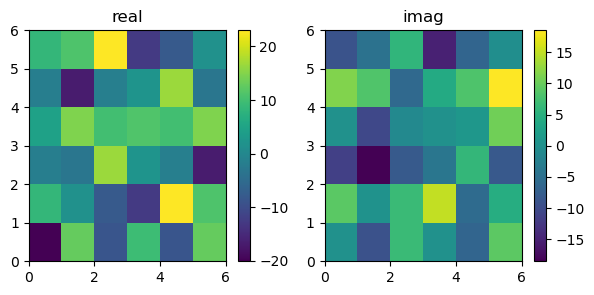

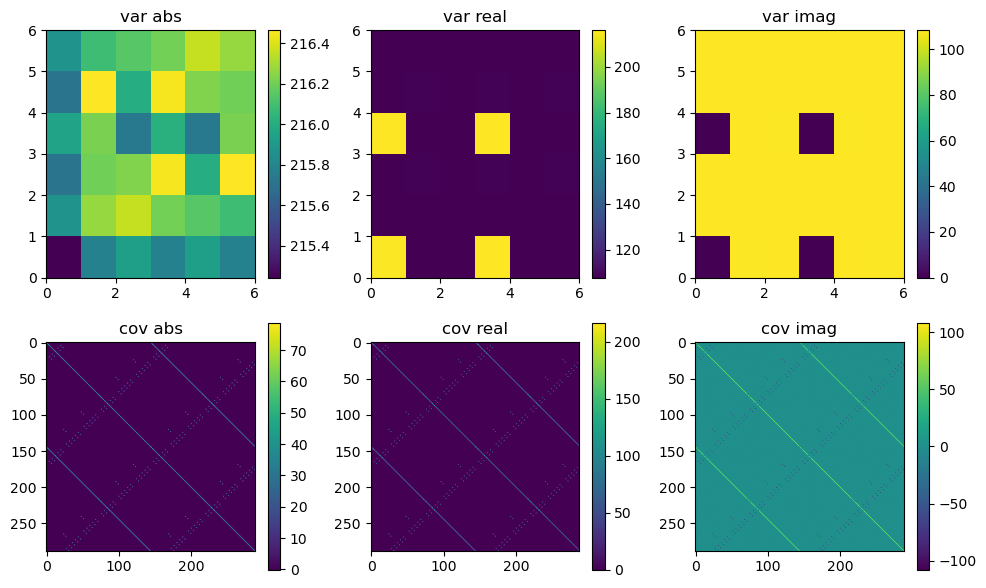

In [ ]:
# fourier = vmap(partial(jnp.fft.rfftn, norm="ortho"))(spatial)
norm = "backward"
# norm = "ortho"
# norm = "forward"
fourier = vmap(partial(jnp.fft.rfftn, norm=norm))(spatial)
Cs_rfftn = plot_fourier(fourier, ids)

shape: (1000000, 6, 6, 4)
n_unique comp:  (144,)
n_unique real:  (112,)
n_unique imag:  (105,)
n_unique total:  217 vs. 216 +1 because of zero


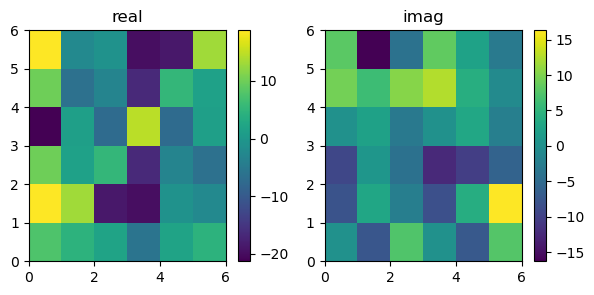

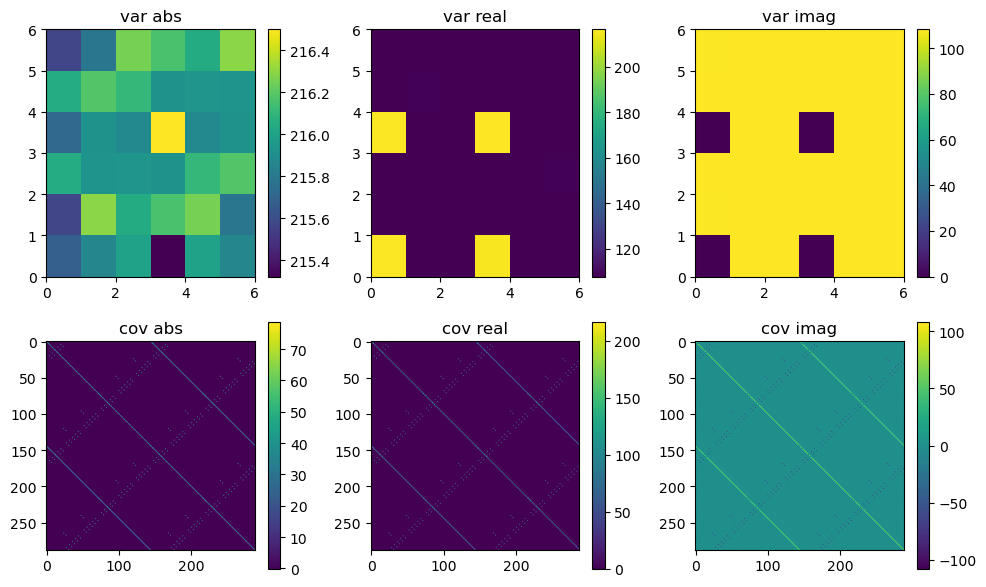

In [ ]:
from montecosmo.utils import rg2cgh, cgh2rg
from montecosmo.utils import rg2cgh2, cgh2rg2
fourier = vmap(partial(rg2cgh, norm=norm))(spatial)
spatial2 = vmap(partial(cgh2rg, norm=norm))(fourier)
assert_allclose(spatial, spatial2, rtol=1e-5)
Cs_rg2cgh = plot_fourier(fourier, ids)
assert_allclose(Cs_rfftn, Cs_rg2cgh, rtol=1e-5, atol=1.)

In [15]:
import math

@jit
def genrete_realx_gaussian_field_3d_k_mask(randns, dtype=jnp.float64, cdtype=jnp.complex128):
    """
    randns is an array with nc^3 standard normal vars
    """
    #import numpy as jnp    # change to jax after! fixme
    
    randns = randns.flatten()
    nc = round(randns.shape[0]**(1./3))
    
    # due to G*(f) = G(-f) symmetry, the return value will have shape nc,nc/2+1 (assuming d even)
    n = round(nc/2)+1
    
    ret = jnp.zeros(shape=(nc,nc,n,), dtype=cdtype) 
    
    # grid for masking
    #grid0, grid1, grid2 = jnp.meshgrid(jnp.arange(nc), jnp.arange(nc), jnp.arange(n))
     
    # fill all non k2=0 and nyq voxels with complex number  (n-1 is nyq)
    s = (nc, nc, n-2)
    m = math.prod(s)
    
    #mask = (1 <= grid2) * (grid2 < n-1)
    pads = ((0,0), (0,0), (1,1))    # need to pad r such that it has same shape as mask, and aligns with the 1s.  # fixme, can completely remove mask!
    
    i = 0         # running index for taking dofs    for neatness, always have i= above r=
    r = randns[i:i+m].reshape(s)    # do sqrt2 just before end
    i += m
    
    ret += jnp.pad(r, pads)
    
    r = randns[i:i+m].reshape(s) * 1j
    i += m
    
    ret += jnp.pad(r, pads)
    
    # fill k2=0 nyq>k0>0  (note use of n in firt index now) only want to fill half and then will conj flip by sim.
    # we have a choice to reflect in axis 0 or 1. we chose to reflect in 1 first, 
    # so compared to 2d we just have an extra :, at the beginnign.
    # but then we'll have anthertep to reflect in 0 dimension
    # to keep track of rands easily will do reflection conj by hand.
    s = (nc, n-2, 1)
    m = math.prod(s)
    for b in [0,n-1]:                                # same methodology for when grid2=0 or nyq, o loop
        
        r = randns[i:i+m].reshape(s)
        i += m
        
        pads = [None, None, None]   # save space by updating pads[i] depending on line.
        if   b == 0:   pads[2] = (0,n-1)   # pads[2] is the same throughout loop
        elif b == n-1: pads[2] = (n-1,0) 
        
        #mask = (1 <= grid1) * (grid1 < n-1) * (grid2 == b)
        pads[0] = (0,0)
        pads[1] = (1,n-1)
        
        ret += jnp.pad(r, pads)
        
        # do reflections for grid2=0 before shifting randns for imaginary part agin lots of steps: now we will need to pad AND mask
        # padding ofc needed for shape as above, and mask needed because we want to only reflect certain subregions of r each time)
        #pads[1] = (n,0)   # same for all of these reflections
        
        
        # real part reflections. recall r is unpadded, so simple ::-1 (in 1 index) followed by appropriate padding and 0 index works!
        pads[1] = (n,0)   # the 1 axis always wants these pads for the mirror region
        #mask = (grid0 == 0) * (n <= grid1) * (grid2 == b) 
        pads[0] = (0,nc-1)
        ret += jnp.pad(r[0,::-1,b][None,:,None], pads)
        #mask = (grid0 == n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (n-1,n-2)
        ret += jnp.pad(r[n-1,::-1,b][None,:,None], pads) 
        #mask = (n <= grid0) * (n <= grid1) * (grid2 == b) 
        pads[0] = (n,0)
        ret += jnp.pad(r[n-2:0:-1,::-1,b][:,:,None], pads)
        #mask = (1 <= grid0) * (grid0 < n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (1,n-1)
        ret += jnp.pad(r[:n-1:-1,::-1,b][:,:,None], pads)
        
        # now do same for imaginary part
        r = randns[i:i+m].reshape(s) * 1j
        i += m
        
        #mask = (1 <= grid1) * (grid1 < n-1) * (grid2 == b)
        pads[0] = (0,0)
        pads[1] = (1,n-1)
        
        ret += jnp.pad(r, pads)
        
        # do reflections for grid2=0 before shifting randns for imaginary part agin lots of steps. - for conj
        pads[1] = (n,0)   # the 1 axis always wants these pads for the mirror region
        #mask = (grid0 == 0) * (n <= grid1) * (grid2 == b)
        pads[0] = (0,nc-1)
        ret -= jnp.pad(r[0,::-1,b][None,:,None], pads)
        #mask = (grid0 == n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (n-1,n-2)
        ret -= jnp.pad(r[n-1,::-1,b][None,:,None], pads)
        #mask = (n <= grid0) * (n <= grid1) * (grid2 == b)
        pads[0] = (n,0)
        ret -= jnp.pad(r[n-2:0:-1,::-1,b][:,:,None], pads)
        #mask = (1 <= grid0) * (grid0 < n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (1,n-1)
        ret -= jnp.pad(r[:n-1:-1,::-1,b][:,:,None], pads)
        
    # now we fill the remaining lines across the 0 axis
    s = (n-2, 1, 1)
    m = math.prod(s)
    for b2 in [0, n-1]:
        for b1 in [0, n-1]:
            r = randns[i:i+m].reshape(s)
            i += m
            
            pads = [None, None, None]   # save space by updating pads[i] depending on line.
            if   b2 == 0:   pads[2] = (0,n-1)   # pads[2] is the same throughout loop
            elif b2 == n-1: pads[2] = (n-1,0) 
            if   b1 == 0:   pads[1] = (0,nc-1)   # pads[1] is the same throughout loop
            elif b1 == n-1: pads[1] = (n-1,n-2) 

            # real
            #mask = (1 <= grid0) * (grid0 < n-1) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (1,n-1)
            ret += jnp.pad(r, pads)
            # reflect
            #mask = (n <= grid0) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (n,0)
            ret += jnp.pad(r[::-1, b1, b2][:,None,None], pads)         #n-2:0:-1
            
            
            r = randns[i:i+m].reshape(s) * 1j
            i += m
            
            # im
            #mask = (1 <= grid0) * (grid0 < n-1) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (1,n-1)
            ret += jnp.pad(r, pads)
            # reflect
            #mask = (n <= grid0) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (n,0)
            ret -= jnp.pad(r[::-1, b1, b2][:,None,None], pads)
    
    # divide everyhting by sqrt(2) before doing real components
    ret /= jnp.sqrt(2)
    
    # now fill in real parts
    s = (1, 1, 1)
    m = math.prod(s)
    for b2 in [0, n-1]:
        for b1 in [0, n-1]:
            for b0 in [0, n-1]:
                
                pads = [None, None, None]   # save space by updating pads[i] depending on line.
                if   b2 == 0:   pads[2] = (0,n-1)   # pads[2] is the same throughout loop
                elif b2 == n-1: pads[2] = (n-1,0) 
                if   b1 == 0:   pads[1] = (0,nc-1)   # pads[1] is the same throughout loop
                elif b1 == n-1: pads[1] = (n-1,n-2) 
                if   b0 == 0:   pads[0] = (0,nc-1)   # pads[0] is the same throughout loop
                elif b0 == n-1: pads[0] = (n-1,n-2) 

                r = randns[i:i+m].reshape(s)
                i += m
    
                #mask = (grid0 == b0) * (grid1 == b1) * (grid2 == b2)
                ret += jnp.pad(r, pads)
            
    assert(i == nc**3)
    
    return ret #jnp.asarray(ret)


/tmp/ipykernel_22133/4017080917.py:16: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ret = jnp.zeros(shape=(nc,nc,n,), dtype=cdtype)


shape: (1000000, 6, 6, 4)
n_unique comp:  (144,)
n_unique real:  (112,)
n_unique imag:  (105,)
n_unique total:  217 vs. 216 +1 because of zero


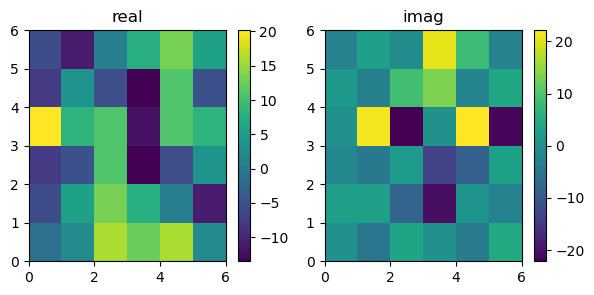

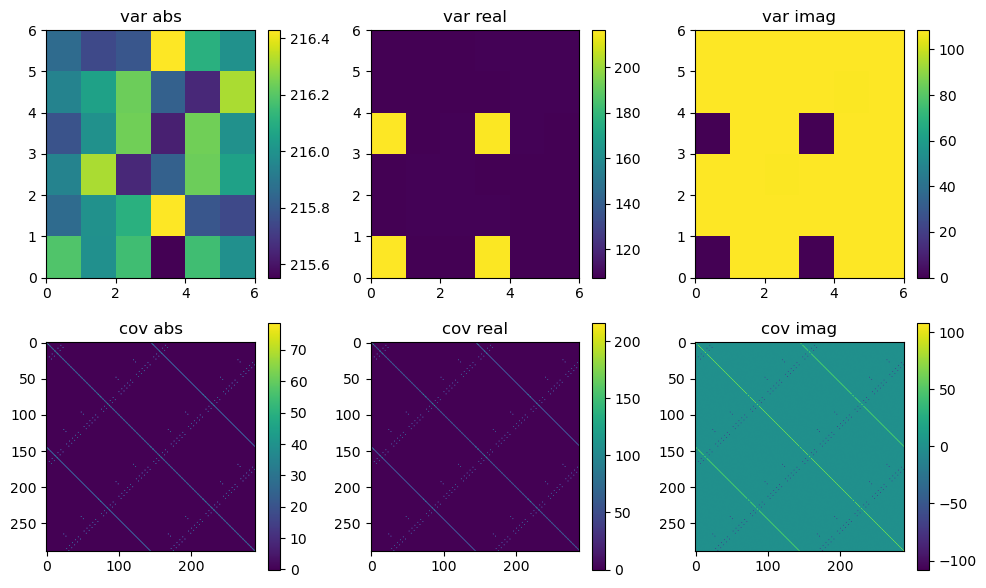

In [ ]:
fourier = vmap(genrete_realx_gaussian_field_3d_k_mask)(spatial)
fourier *= jnp.array(size).prod()**.5
Cs_generate = plot_fourier(fourier, ids)
assert_allclose(Cs_rfftn, Cs_generate, rtol=1e-5, atol=1)

In [13]:
# Create NumPy and JAX Numpy arrays
arr = [True, False, True]
np_bool_array = np.array(arr, dtype=bool)
np_int_array = np.array(arr, dtype=int)
jax_bool_array = jnp.array(arr, dtype=bool)
jax_int_array = jnp.array(arr, dtype=int)

# Print memory sizes
print("NumPy boolean array size:", np_bool_array.nbytes, "bytes")
print("NumPy integer array size:", np_int_array.nbytes, "bytes")
print("JAX NumPy boolean array size:", jax_bool_array.nbytes, "bytes")
print("JAX NumPy integer array size:", jax_int_array.nbytes, "bytes")

NumPy boolean array size: 3 bytes
NumPy integer array size: 24 bytes
JAX NumPy boolean array size: 3 bytes
JAX NumPy integer array size: 12 bytes


# Reparam any Complex Gaussian Hermitian tensor

In [2]:
from montecosmo.bricks import lin_power_mesh, Planck18
from montecosmo.utils import rg2cgh, cgh2rg
from montecosmo.utils import rg2cgh2, cgh2rg2
# from montecosmo.utils import rg2cgh2 as rg2cgh, cgh2rg2 as cgh2rg
from montecosmo.metrics import spectrum
import numpy as np
from jax import random as jr, numpy as jnp, vmap
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# n_rep = 10_000
# n_rep = 1_000
n_rep = 500
a = 1.
cosmo = Planck18()
mesh_shape = 3*(64,)
# mesh_shape = 3*(128,)
box_size = np.array([640,640,640])
norm = "backward"
# norm = "ortho"
# norm = "forward"
std_mesh = lin_power_mesh(cosmo, mesh_shape, box_size, a)
mu_mesh = jnp.fft.rfftn(jr.normal(jr.key(33), mesh_shape), norm=norm)

def ref_mesh_fn(rng):
    seed_mesh = jr.normal(rng, mesh_shape)

    # mesh = jnp.fft.rfftn(seed_mesh, norm=norm)
    mesh = rg2cgh(seed_mesh, norm=norm)

    # mesh = std_mesh * mesh + mu_mesh
    mesh = std_mesh * mesh + mu_mesh
    # mesh = jnp.fft.irfftn(mesh, norm=norm)

    mesh2 = rg2cgh2(seed_mesh, norm=norm)
    mesh2 = std_mesh * mesh2 + mu_mesh
    return mesh, mesh2

ref_meshes, ref_meshes2 = vmap(ref_mesh_fn)(jr.split(jr.key(0), n_rep))
ref_mean, ref_std = ref_meshes.mean(0), ref_meshes.std(0)
ref_mean2, ref_std2 = ref_meshes2.mean(0), ref_meshes2.std(0)

def our_mesh_fn(rng):
    seed_mesh = jr.normal(rng, mesh_shape)
    seed_mesh = seed_mesh * cgh2rg(std_mesh, norm="amp") + cgh2rg(mu_mesh, norm=norm)
    # seed_mesh = seed_mesh * cgh2rg(std_mesh, norm=norm, amp=True) + cgh2rg(mu_mesh, norm=norm)
    
    mesh = rg2cgh(seed_mesh, norm=norm)
    # mesh = jnp.fft.irfftn(mesh, norm=norm)
    return mesh

our_meshes = vmap(our_mesh_fn)(jr.split(jr.key(0), n_rep))
our_mean, our_std = our_meshes.mean(0), our_meshes.std(0)

2025-04-26 20:22:48.090886: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


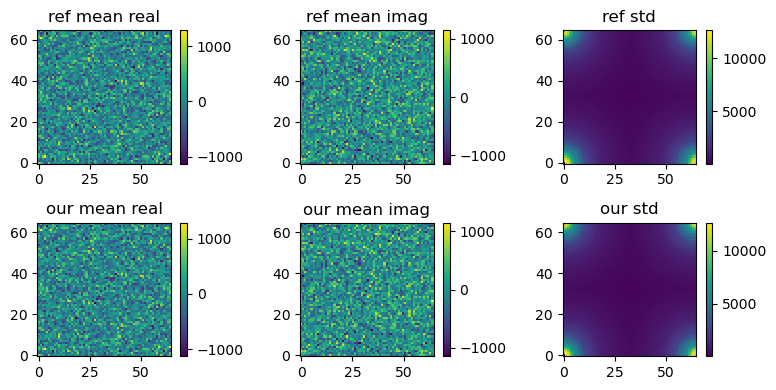

In [9]:
from montecosmo.plot import plot_mesh, plot_pow, plot_bivar
sli = 1
plt.figure(figsize=(8,4))
plt.subplot(231)
plot_mesh(ref_mean.real, sli=sli)
plt.colorbar(), plt.title("ref mean real")
plt.subplot(232)
plot_mesh(ref_mean.imag, sli=sli)
plt.colorbar(), plt.title("ref mean imag")
plt.subplot(233)
plot_mesh(ref_std, sli=sli)
plt.colorbar(), plt.title("ref std")

plt.subplot(234)
plot_mesh(our_mean.real, sli=sli)
plt.colorbar(), plt.title("our mean real")
plt.subplot(235)
plot_mesh(our_mean.imag, sli=sli)
plt.colorbar(), plt.title("our mean imag")
plt.subplot(236)
plot_mesh(our_std, sli=sli)
plt.colorbar(), plt.title("our std")
plt.tight_layout()

from numpy.testing import assert_allclose
tol = 1e-5
assert_allclose(ref_mean, ref_mean2, rtol=tol, atol=tol)
assert_allclose(ref_std, ref_std2, rtol=tol, atol=tol)
assert_allclose(ref_meshes, ref_meshes2, rtol=tol, atol=tol)

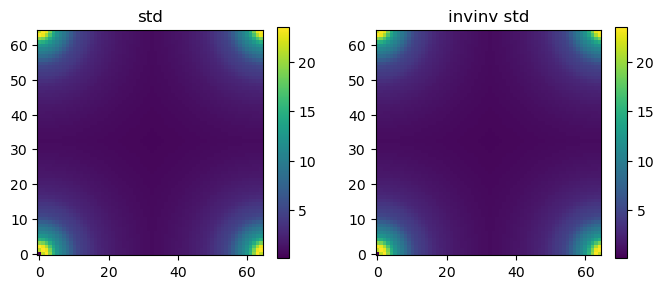

In [7]:
invinv = rg2cgh(cgh2rg(std_mesh, norm="amp"), norm="amp")
# invinv = rg2cgh(cgh2rg(std_mesh, norm=norm, amp=True), norm=norm, amp=True)
sli = 1
plt.figure(figsize=(8,3))
plt.subplot(121)
plot_mesh(std_mesh, sli=sli)
plt.colorbar(), plt.title("std")
plt.subplot(122)
plot_mesh(invinv, sli=sli)
plt.colorbar(), plt.title("invinv std")

tol = 1e-7
assert_allclose(invinv, std_mesh, rtol=tol, atol=tol)

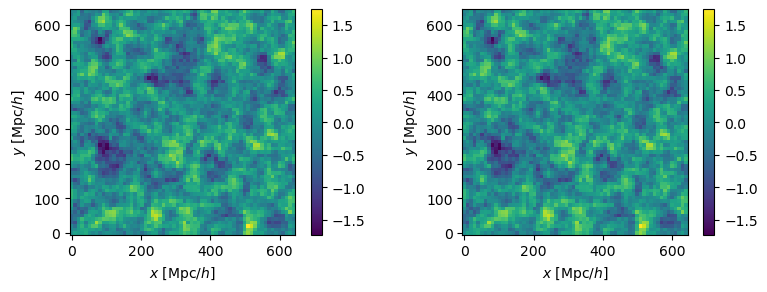

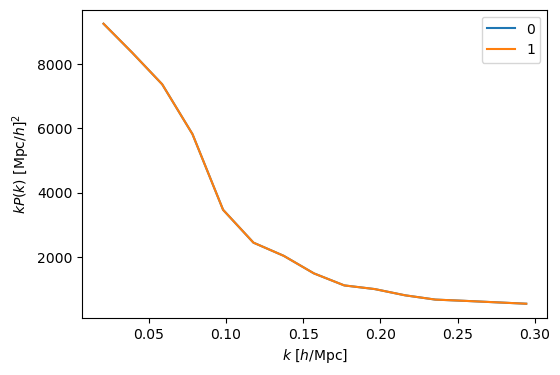

In [30]:
from montecosmo.plot import plot_mesh, plot_pow, plot_bivar
meshes = []
meshes.append(jnp.fft.irfftn(ref_meshes[0]))
meshes.append(jnp.fft.irfftn(our_meshes[0]))

plt.figure(figsize=(8, 3))
for i_plt, mesh in enumerate(meshes):
    plt.subplot(1,len(meshes),i_plt+1)
    plot_mesh(mesh, box_size)
    plt.colorbar()
plt.tight_layout()

plt.figure(figsize=(6, 4))
for i_plt, mesh in enumerate(meshes):
    kpk = spectrum(mesh, box_size=box_size)
    plot_pow(*kpk, label=f"{i_plt}")
plt.legend()
plt.show()

# Reshape Complex Hermitian tensor

## Problem

m2: ref 0.44417049710306855 correct 0.22573751662481412 naive 0.2246932073410783 corrected 0.22585893928681433


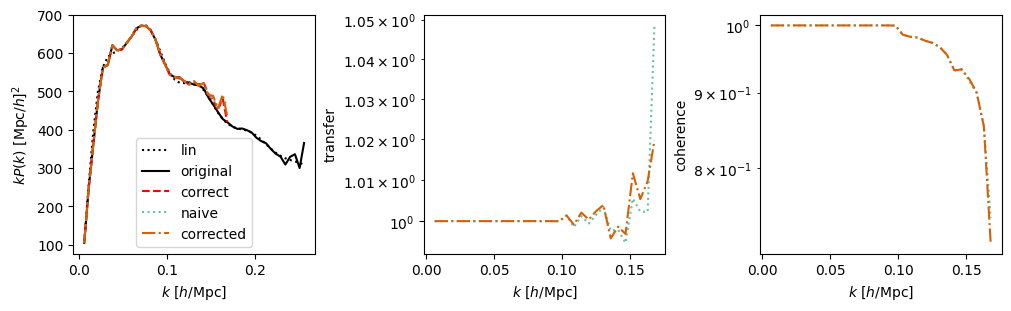

In [3]:
from montecosmo.metrics import spectrum
from montecosmo.utils import r2chshape, chreshape, _chreshape, cgh2rg, rg2cgh
from montecosmo.bricks import lin_power_mesh, lin_power_interp, Planck18
from montecosmo.nbody import rfftk, fftk
from montecosmo.metrics import spectrum, powtranscoh
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_mesh, theme
theme()

init_shape = np.array(3*(96,))
box_size = np.array(3* (2000,))
cosmo = Planck18()
# kvec = rfftk(shape, box_size)
# kmesh = sum(ki**2 for ki in kvec)**0.5
pmesh = lin_power_mesh(cosmo, mesh_shape=init_shape, box_size=box_size)
# pmesh = lin_power_interp(cosmo)(kmesh)

fin_shape = 3*[64]
n_rep = 1

def tovmap(seed):
    delta1 = jnp.fft.rfftn(jr.normal(jr.key(seed), init_shape))
    delta1 *= pmesh**0.5
    delta2 = chreshape(delta1, shape=r2chshape(fin_shape))
    delta_naive2 = _chreshape(delta1, shape=delta2.shape)
    delta_corrected2 = rg2cgh(cgh2rg(delta_naive2))

    kpows1 = spectrum(delta1, box_size=box_size)
    kpows2 = spectrum(delta2, box_size=box_size)
    kptc_naive2 = powtranscoh(delta2, delta_naive2, box_size=box_size)
    kptc_corrected2 = powtranscoh(delta2, delta_corrected2, box_size=box_size)
    kpow_lin = kpows1[0], lin_power_interp(cosmo)(kpows1[0])

    delta1 = jnp.fft.irfftn(delta1)
    delta2 = jnp.fft.irfftn(delta2)
    delta_naive2 = jnp.fft.irfftn(delta_naive2)
    delta_corrected2 = jnp.fft.irfftn(delta_corrected2)
    m2_1, m2_2, m2_naive2, m2_corrected2 = (delta1**2).mean(), (delta2**2).mean(), (delta_naive2**2).mean(), (delta_corrected2**2).mean()
    return kpow_lin, kpows1, kpows2, kptc_naive2, kptc_corrected2, m2_1, m2_2, m2_naive2, m2_corrected2

out = vmap(tovmap)(jnp.arange(n_rep))
kpow_lin, kpows1, kpows2, kptc_naive2, kptc_corrected2, m2_1, m2_2, m2_naive2, m2_corrected2 = tree.map(lambda x: jnp.mean(x, 0), out)

log = False
plt.figure(figsize=(10,3), layout="constrained")
plt.subplot(131)
plot_pow(*kpow_lin, 'k:', log=log, label="lin")
plot_pow(*kpows1, 'k', log=log, label="original")
plot_pow(*kpows2, 'r--', log=log, label="correct")
plot_powtranscoh(*kptc_naive2, ':', log=log, label="naive")
plot_powtranscoh(*kptc_corrected2, '-.', log=log, label="corrected")
plt.subplot(131)
plt.legend()
print("m2: ref", m2_1, "correct", m2_2, "naive", m2_naive2, "corrected", m2_corrected2)

m2: ref 0.22593441446458032 correct 0.22593441446458043 naive 0.2279518244153774 corrected 0.22802663307684884


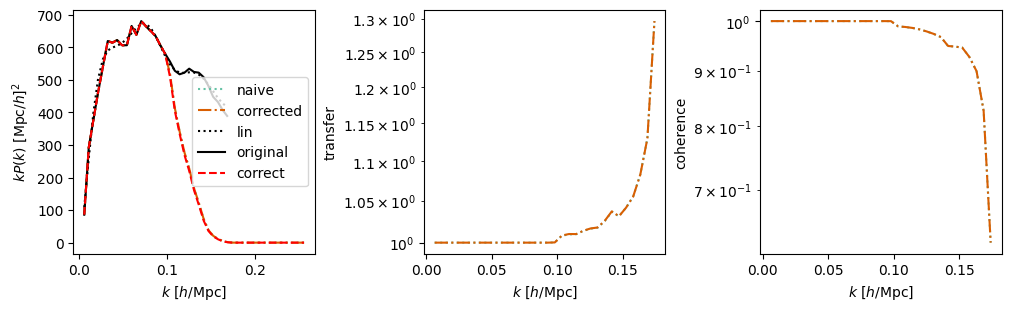

In [ ]:
from montecosmo.metrics import spectrum
from montecosmo.utils import r2chshape, chreshape, _chreshape, cgh2rg, rg2cgh
from montecosmo.bricks import lin_power_mesh, lin_power_interp, Planck18
from montecosmo.nbody import rfftk, fftk
from montecosmo.metrics import spectrum, powtranscoh
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_mesh, theme
theme()

init_shape = np.array(3*(64,))
box_size = np.array(3* (2000,))
cosmo = Planck18()
# kvec = rfftk(shape, box_size)
# kmesh = sum(ki**2 for ki in kvec)**0.5
pmesh = lin_power_mesh(cosmo, mesh_shape=init_shape, box_size=box_size)
# pmesh = lin_power_interp(cosmo)(kmesh)

fin_shape = 3*[96]
n_rep = 1

def tovmap(seed):
    delta1 = jnp.fft.rfftn(jr.normal(jr.key(seed), init_shape))
    delta1 *= pmesh**0.5
    delta2 = chreshape(delta1, shape=r2chshape(fin_shape))
    delta_naive2 = _chreshape(delta1, shape=delta2.shape)
    delta_corrected2 = rg2cgh(cgh2rg(delta_naive2))

    kpows1 = spectrum(delta1, box_size=box_size)
    kpows2 = spectrum(delta2, box_size=box_size)
    kptc_naive2 = powtranscoh(delta2, delta_naive2, box_size=box_size)
    kptc_corrected2 = powtranscoh(delta2, delta_corrected2, box_size=box_size)
    kpow_lin = kpows1[0], lin_power_interp(cosmo)(kpows1[0])

    delta1 = jnp.fft.irfftn(delta1)
    delta2 = jnp.fft.irfftn(delta2)
    delta_naive2 = jnp.fft.irfftn(delta_naive2)
    delta_corrected2 = jnp.fft.irfftn(delta_corrected2)
    m2_1, m2_2, m2_naive2, m2_corrected2 = (delta1**2).mean(), (delta2**2).mean(), (delta_naive2**2).mean(), (delta_corrected2**2).mean()
    return kpow_lin, kpows1, kpows2, kptc_naive2, kptc_corrected2, m2_1, m2_2, m2_naive2, m2_corrected2

out = vmap(tovmap)(jnp.arange(n_rep))
kpow_lin, kpows1, kpows2, kptc_naive2, kptc_corrected2, m2_1, m2_2, m2_naive2, m2_corrected2 = tree.map(lambda x: jnp.mean(x, 0), out)

log = False
plt.figure(figsize=(10,3), layout="constrained")
plt.subplot(131)
plot_pow(*kpow_lin, 'k:', log=log, label="lin")
plot_pow(*kpows1, 'k', log=log, label="original")
plot_pow(*kpows2, 'r--', log=log, label="correct")
plot_powtranscoh(*kptc_naive2, ':', log=log, label="naive")
plot_powtranscoh(*kptc_corrected2, '-.', log=log, label="corrected")
plt.subplot(131)
plt.legend()
print("m2: ref", m2_1, "correct", m2_2, "naive", m2_naive2, "corrected", m2_corrected2)

m2: ref 0.22596969241135342 chreshape 0.09152263051191437 naive chreshape 0.09065608577198196


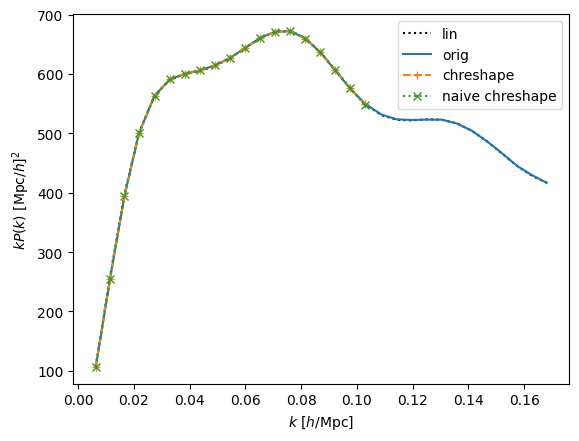

In [ ]:
from montecosmo.metrics import spectrum
from montecosmo.utils import r2chshape, chreshape, _chreshape
from montecosmo.bricks import lin_power_mesh, lin_power_interp, Planck18
from montecosmo.nbody import rfftk, fftk
from montecosmo.metrics import spectrum, powtranscoh
from montecosmo.plot import plot_pow, plot_mesh

init_shape = np.array(3*(64,))
box_size = np.array(3* (2000,))
cosmo = Planck18()
# kvec = rfftk(shape, box_size)
# kmesh = sum(ki**2 for ki in kvec)**0.5
pmesh = lin_power_mesh(cosmo, mesh_shape=init_shape, box_size=box_size)
# pmesh = lin_power_interp(cosmo)(kmesh)

fin_shape = 3*[40]
n_rep = 1000

def tovmap(seed):
    delta1 = jnp.fft.rfftn(jr.normal(jr.key(seed), init_shape))
    delta1 *= pmesh**0.5
    delta2 = chreshape(delta1, shape=r2chshape(fin_shape))
    _delta2 = _chreshape(delta1, shape=delta2.shape)

    kpows1 = spectrum(delta1, box_size=box_size)
    kpows2 = spectrum(delta2, box_size=box_size)
    _kpows2 = spectrum(_delta2, box_size=box_size)
    kpow_lin = kpows1[0], lin_power_interp(cosmo)(kpows1[0])

    delta1 = jnp.fft.irfftn(delta1)
    delta2 = jnp.fft.irfftn(delta2)
    _delta2 = jnp.fft.irfftn(_delta2)
    m2_1, m2_2, _m2_2 = (delta1**2).mean(), (delta2**2).mean(), (_delta2**2).mean()
    return kpow_lin, kpows1, kpows2, _kpows2, m2_1, m2_2, _m2_2

out = vmap(tovmap)(jnp.arange(n_rep))
kpow_lin, kpows1, kpows2, naive_kpows2, m2_1, m2_2, _m2_2 = tree.map(lambda x: jnp.mean(x, 0), out)

log = False
plot_pow(*kpow_lin, 'k:', log=log, label="lin")
plot_pow(*kpows1, log=log, label="orig")
plot_pow(*kpows2, '+--', log=log, label="chreshape")
plot_pow(*naive_kpows2, 'x:', log=log, label="naive chreshape")
plt.legend()
print("m2: ref", m2_1, "chreshape", m2_2, "naive chreshape", _m2_2)

## 1D fft

[ 0.  1.  2. -3. -2. -1.] [ 0.  1.  2.  3.  4.  5.  6. -7. -6. -5. -4. -3. -2. -1.] [ 0.  1.  2. -3. -4. -5. -6. -7. -6. -5. -4. -3. -2. -1.]
sig1 imag: 5.964579274110883e-17 , sig2 naive imag: 0.07081481418472917 , sig2 mean imag: 2.500871694562856e-17 , sig2 comp imag: 2.500871694562856e-17
var: 0.4110740794503416 0.4110740794503415 0.4110740794503416 0.4110740794503416
m2: 0.41823924829302905 0.4182392482930291 0.4182392482930291 0.4182392482930291


/local/home/hs276503/miniforge3/envs/testenv2/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/local/home/hs276503/miniforge3/envs/testenv2/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


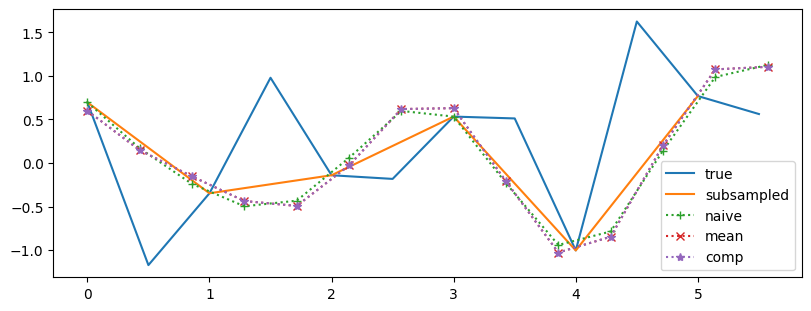

In [8]:
def _creshape(sig, half_pad, shift):
    l = len(sig)
    freq = np.fft.fftfreq(l) * l
    sig = jnp.roll(sig, len(sig)//2 - shift)
    freq = np.roll(freq, len(freq)//2 - shift)

    if half_pad <= 0:
        half_sub = -half_pad
        sig = sig[half_sub:None if half_sub==0 else -half_sub]
        freq = freq[half_sub:None if half_sub==0 else -half_sub]
    else:
        sig = jnp.pad(sig, pad_width=(half_pad, half_pad))
        freq = np.pad(freq, pad_width=(half_pad, half_pad), mode='linear_ramp', end_values=(freq[0]+np.sign(freq[0])*half_pad, freq[-1]+np.sign(freq[-1])*half_pad))

    sig = jnp.roll(sig, -len(sig)//2 + shift)
    freq = np.roll(freq, -len(freq)//2 + shift)
    return sig, freq


def creshape(sig, half_pad):
    sig = jnp.array(sig)
    sig_naive, freq_naive = _creshape(sig, half_pad, shift=0)

    if half_pad > 0:
        sig = sig.at[len(sig)//2].multiply(2**.5)

    sig_naive1, freq_naive1 = _creshape(sig, half_pad, shift=0)
    sig_naive2, freq_naive2 = _creshape(sig, half_pad, shift=1)

    sig_mean = (sig_naive1 + sig_naive2) / 2
    sig_comp = sig_mean.copy()

    if half_pad < 0:
        sig_comp = sig_comp.at[len(sig_comp)//2].multiply(2**.5)
    return sig_naive, sig_mean, sig_comp, freq_naive, freq_naive2

l = 12
sig1_true = jr.normal(jr.key(43), (l,))
freq1_true = np.fft.fftfreq(l) * l
sig1_true = np.fft.fft(sig1_true) * np.exp(-freq1_true**2 * .01)
sig1_true = np.fft.ifft(sig1_true)

sig1 = np.fft.fft(sig1_true[::2])
freq1 = np.fft.fftfreq(len(sig1)) * len(sig1)

sig2_naive, sig2_mean, sig2_comp, freq2_naive, freq2_naive2 = creshape(sig1, half_pad=4)
print(freq1, freq2_naive, freq2_naive2)



sig1 = np.fft.ifft(sig1)
sig2_naive = np.fft.ifft(sig2_naive)
sig2_mean = np.fft.ifft(sig2_mean)
sig2_comp = np.fft.ifft(sig2_comp)
print("sig1 imag:", (sig1.imag**2).mean()**.5, ", sig2 naive imag:", (sig2_naive.imag**2).mean()**.5, 
      ", sig2 mean imag:", (sig2_mean.imag**2).mean()**.5, ", sig2 comp imag:", (sig2_comp.imag**2).mean()**.5)

plt.figure(figsize=(8,3), layout="constrained")
plt.plot(np.arange(len(sig1_true)) / len(sig1_true) * len(sig1), sig1_true, label='true')
plt.plot(sig1, label='subsampled')
scale = len(sig2_comp) / len(sig1)
sig2_comp *= scale
sig2_mean *= scale
sig2_naive *= scale
plt.plot(np.arange(len(sig2_naive)) / scale, sig2_naive, ':+', label="naive")
plt.plot(np.arange(len(sig2_mean)) / scale, sig2_mean, ':x', label="mean")
plt.plot(np.arange(len(sig2_comp)) / scale, sig2_comp, ':*', label="comp")

# plt.plot(np.arange(len(sig2_naive)) / scale, sig2_naive - sig1_true, ':+', label="naive")
# plt.plot(np.arange(len(sig2_mean)) / scale, sig2_mean - sig1_true, ':x', label="mean")
# plt.plot(np.arange(len(sig2_comp)) / scale, sig2_comp - sig1_true, ':*', label="comp")
print("var:", jnp.var(sig1), jnp.var(sig2_naive), jnp.var(sig2_mean), jnp.var(sig2_comp))
print("m2:", jnp.abs(sig1**2).mean(), jnp.abs(sig2_naive**2).mean(), jnp.abs(sig2_mean**2).mean(), jnp.abs(sig2_comp**2).mean())
plt.legend();

Text(0.5, 1.0, 'std real and imag')

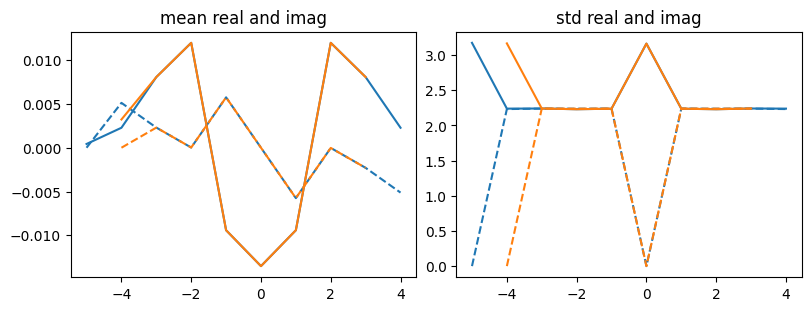

In [9]:
l = 10
half_pad = -1
def tovmap(seed):
    sig1 = jr.normal(seed, (l,))
    sig1 = jnp.fft.fft(sig1)
    sig2_naive, sig2_mean, sig2_comp, freq2_naive, freq2_naive2 = creshape(sig1, half_pad)
    # scale = len(sig2_comp) / len(sig1)
    # sig2_comp *= scale
    return sig1, sig2_comp

n_rep = 100000
seeds = jr.split(jr.key(42), n_rep)
sig1s, sig2s = vmap(tovmap)(seeds)
mean1, mean2 = sig1s.mean(0), sig2s.mean(0)
std1r, std2r = sig1s.real.std(0), sig2s.real.std(0)
std1i, std2i = sig1s.imag.std(0), sig2s.imag.std(0)

scale = len(sig2s[0]) / len(sig1s[0])
freq1 = np.fft.fftshift(np.fft.fftfreq(len(sig1s[0])) * len(sig1s[0]))
freq2 = np.fft.fftshift(np.fft.fftfreq(len(sig2s[0])) * len(sig2s[0]))
mean1 = np.fft.fftshift(mean1)
mean2 = np.fft.fftshift(mean2)
std1r = np.fft.fftshift(std1r)
std2r = np.fft.fftshift(std2r)
std1i = np.fft.fftshift(std1i)
std2i = np.fft.fftshift(std2i)


plt.figure(figsize=(8,3), layout="constrained")
plt.subplot(121)
plt.plot(freq1, mean1.real, 'C0')
plt.plot(freq1, mean1.imag, 'C0--')
plt.plot(freq2, mean2.real, 'C1')
plt.plot(freq2, mean2.imag, 'C1--')
plt.title("mean real and imag")

plt.subplot(122)
plt.plot(freq1, std1r, 'C0')
plt.plot(freq1, std1i, 'C0--')
plt.plot(freq2, std2r, 'C1')
plt.plot(freq2, std2i, 'C1--')
plt.title("std real and imag")

Text(0.5, 1.0, 'std real and imag')

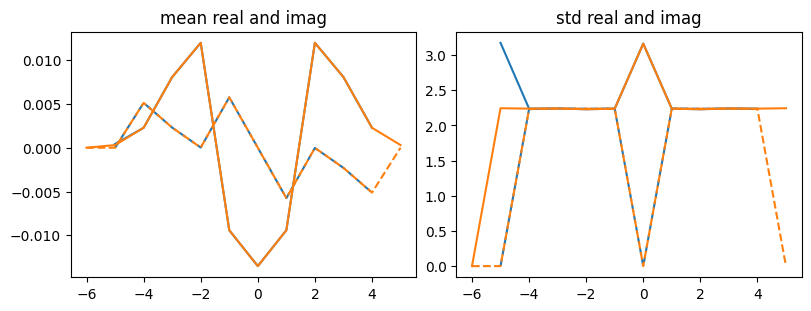

In [10]:
l = 10
half_pad = 1
def tovmap(seed):
    sig1 = jr.normal(seed, (l,))
    sig1 = jnp.fft.fft(sig1)
    sig2_naive, sig2_mean, sig2_comp, freq2_naive, freq2_naive2 = creshape(sig1, half_pad)
    # scale = len(sig2_comp) / len(sig1)
    # sig2_comp *= scale
    return sig1, sig2_comp

n_rep = 100000
seeds = jr.split(jr.key(42), n_rep)
sig1s, sig2s = vmap(tovmap)(seeds)
mean1, mean2 = sig1s.mean(0), sig2s.mean(0)
std1r, std2r = sig1s.real.std(0), sig2s.real.std(0)
std1i, std2i = sig1s.imag.std(0), sig2s.imag.std(0)

scale = len(sig2s[0]) / len(sig1s[0])
freq1 = np.fft.fftshift(np.fft.fftfreq(len(sig1s[0])) * len(sig1s[0]))
freq2 = np.fft.fftshift(np.fft.fftfreq(len(sig2s[0])) * len(sig2s[0]))
mean1 = np.fft.fftshift(mean1)
mean2 = np.fft.fftshift(mean2)
std1r = np.fft.fftshift(std1r)
std2r = np.fft.fftshift(std2r)
std1i = np.fft.fftshift(std1i)
std2i = np.fft.fftshift(std2i)


plt.figure(figsize=(8,3), layout="constrained")
plt.subplot(121)
plt.plot(freq1, mean1.real, 'C0')
plt.plot(freq1, mean1.imag, 'C0--')
plt.plot(freq2, mean2.real, 'C1')
plt.plot(freq2, mean2.imag, 'C1--')
plt.title("mean real and imag")

plt.subplot(122)
plt.plot(freq1, std1r, 'C0')
plt.plot(freq1, std1i, 'C0--')
plt.plot(freq2, std2r, 'C1')
plt.plot(freq2, std2i, 'C1--')
plt.title("std real and imag")

## 1D rfft

[0. 1. 2. 3.] [0. 1. 2.]
sig1 imag: 0.0 , sig2 naive imag: 0.0 , sig2 comp imag: 0.0
var: 0.4110740794503415 0.12278762819112775 0.19312908463848033
m2: 0.41823924829302894 0.1299527970338153 0.20029425348116783


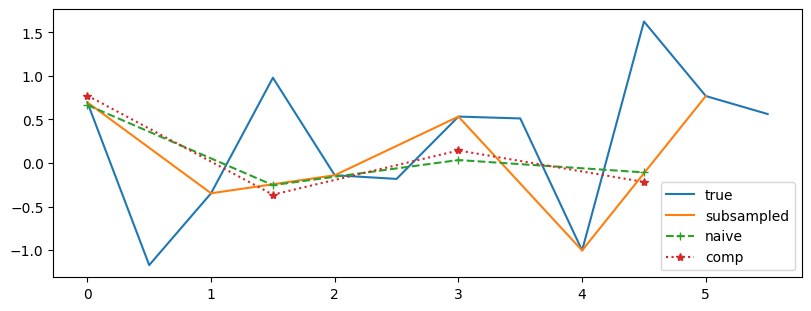

In [34]:
def _rcreshape(sig, half_pad):
    l = len(jnp.fft.irfftn(sig))
    freq = np.fft.rfftfreq(l) * l

    if half_pad <= 0:
        half_sub = -half_pad
        sig = sig[:None if half_sub==0 else -half_sub]
        freq = freq[:None if half_sub==0 else -half_sub]
    else:
        sig = jnp.pad(sig, pad_width=(0, half_pad))
        freq = np.pad(freq, pad_width=(0, half_pad), mode='linear_ramp', end_values=freq[-1]+np.sign(freq[-1])*half_pad)

    return sig, freq

def rcreshape(sig, half_pad):
    sig = jnp.array(sig)
    sig_naive, freq_naive = _rcreshape(sig, half_pad)

    if half_pad > 0:
        sig = sig.at[-1].divide(2**.5)

    sig_comp, freq_naive = _rcreshape(sig, half_pad)

    if half_pad < 0:
        sig_comp = sig_comp.at[-1].set(sig_comp[-1].real * 2**.5)
    return sig_naive, sig_comp, freq_naive


l = 12
sig1_true = jr.normal(jr.key(43), (l,))
freq1_true = np.fft.rfftfreq(l) * l
sig1_true = np.fft.rfft(sig1_true) * np.exp(-freq1_true**2 * .01)
sig1_true = np.fft.irfft(sig1_true)

sig1 = sig1_true[::2]
freq1 = np.fft.rfftfreq(len(sig1)) * len(sig1)
sig1 = np.fft.rfft(sig1)

sig2_naive, sig2_comp, freq2_naive = rcreshape(sig1, half_pad=-1)
print(freq1, freq2_naive)


sig1 = np.fft.irfft(sig1)
sig2_naive = np.fft.irfft(sig2_naive)
sig2_comp = np.fft.irfft(sig2_comp)
print("sig1 imag:", (sig1.imag**2).mean()**.5, ", sig2 naive imag:", (sig2_naive.imag**2).mean()**.5, 
      ", sig2 comp imag:", (sig2_comp.imag**2).mean()**.5)

plt.figure(figsize=(8,3), layout="constrained")
plt.plot(np.arange(len(sig1_true)) / len(sig1_true) * len(sig1), sig1_true, label='true')
plt.plot(sig1, label='subsampled')
scale = len(sig2_comp) / len(sig1)
sig2_comp *= scale
sig2_naive *= scale
plt.plot(np.arange(len(sig2_naive)) / scale, sig2_naive, '--+', label="naive")
plt.plot(np.arange(len(sig2_comp)) / scale, sig2_comp, ':*', label="comp")

# plt.plot(np.arange(len(sig2_naive)) / scale, sig2_naive - sig1_true, ':+', label="naive")
# plt.plot(np.arange(len(sig2_comp)) / scale, sig2_comp - sig1_true, ':*', label="comp")
print("var:", jnp.var(sig1), jnp.var(sig2_naive), jnp.var(sig2_comp))
print("m2:", jnp.abs(sig1**2).mean(), jnp.abs(sig2_naive**2).mean(), jnp.abs(sig2_comp**2).mean())
plt.legend();

Text(0.5, 1.0, 'std real and imag')

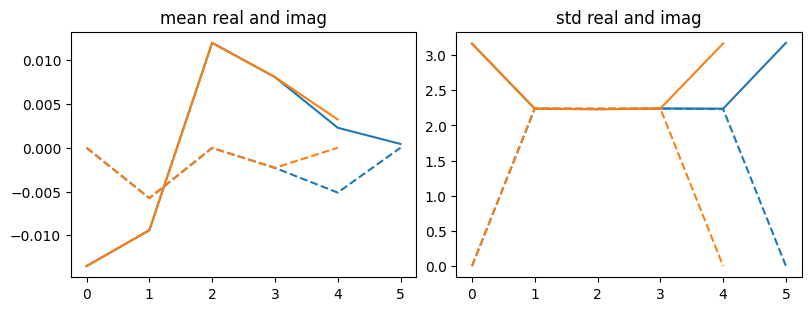

In [35]:
l = 10
half_pad = -1
def tovmap(seed):
    sig1 = jr.normal(seed, (l,))
    sig1 = jnp.fft.rfft(sig1)
    sig2_naive, sig2_comp, freq2_naive = rcreshape(sig1, half_pad)
    # scale = len(sig2_comp) / len(sig1)
    # sig2_comp *= scale
    return sig1, sig2_comp

n_rep = 100000
seeds = jr.split(jr.key(42), n_rep)
sig1s, sig2s = vmap(tovmap)(seeds)
mean1, mean2 = sig1s.mean(0), sig2s.mean(0)
std1r, std2r = sig1s.real.std(0), sig2s.real.std(0)
std1i, std2i = sig1s.imag.std(0), sig2s.imag.std(0)

scale = len(sig2s[0]) / len(sig1s[0])
freq1 = np.fft.rfftfreq(len(jnp.fft.irfftn(sig1s[0]))) * len(jnp.fft.irfftn(sig1s[0]))
freq2 = np.fft.rfftfreq(len(jnp.fft.irfftn(sig2s[0]))) * len(jnp.fft.irfftn(sig2s[0]))

plt.figure(figsize=(8,3), layout="constrained")
plt.subplot(121)
plt.plot(freq1, mean1.real, 'C0')
plt.plot(freq1, mean1.imag, 'C0--')
plt.plot(freq2, mean2.real, 'C1')
plt.plot(freq2, mean2.imag, 'C1--')
plt.title("mean real and imag")

plt.subplot(122)
plt.plot(freq1, std1r, 'C0')
plt.plot(freq1, std1i, 'C0--')
plt.plot(freq2, std2r, 'C1')
plt.plot(freq2, std2i, 'C1--')
plt.title("std real and imag")

patched


Text(0.5, 1.0, 'std real and imag')

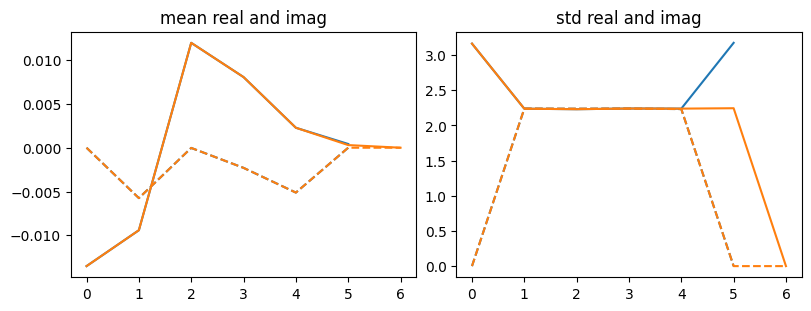

In [ ]:
l = 10
half_pad = 1
def tovmap(seed):
    sig1 = jr.normal(seed, (l,))
    sig1 = jnp.fft.rfft(sig1)
    sig2_naive, sig2_comp, freq2_naive = rcreshape(sig1, half_pad)
    # scale = len(sig2_comp) / len(sig1)
    # sig2_comp *= scale
    return sig1, sig2_comp

n_rep = 100000
seeds = jr.split(jr.key(42), n_rep)
sig1s, sig2s = vmap(tovmap)(seeds)
mean1, mean2 = sig1s.mean(0), sig2s.mean(0)
std1r, std2r = sig1s.real.std(0), sig2s.real.std(0)
std1i, std2i = sig1s.imag.std(0), sig2s.imag.std(0)

scale = len(sig2s[0]) / len(sig1s[0])
freq1 = np.fft.rfftfreq(len(jnp.fft.irfftn(sig1s[0]))) * len(jnp.fft.irfftn(sig1s[0]))
freq2 = np.fft.rfftfreq(len(jnp.fft.irfftn(sig2s[0]))) * len(jnp.fft.irfftn(sig2s[0]))

plt.figure(figsize=(8,3), layout="constrained")
plt.subplot(121)
plt.plot(freq1, mean1.real, 'C0')
plt.plot(freq1, mean1.imag, 'C0--')
plt.plot(freq2, mean2.real, 'C1')
plt.plot(freq2, mean2.imag, 'C1--')
plt.title("mean real and imag")

plt.subplot(122)
plt.plot(freq1, std1r, 'C0')
plt.plot(freq1, std1i, 'C0--')
plt.plot(freq2, std2r, 'C1')
plt.plot(freq2, std2i, 'C1--')
plt.title("std real and imag")

## 2D

In [2]:
from montecosmo.utils import ch2rshape, hermitian_symmetric
from colorsys import hsv_to_rgb, hls_to_rgb

def _chreshape(mesh, shape, rfft=True):
    """
    Naively reshape a complex Hermitian tensor.
    /!\ Does not preserve Hermitian symmetry nor power.
    """
    scale = np.divide(ch2rshape(shape) if rfft else shape, 
                      ch2rshape(mesh.shape) if rfft else mesh.shape).prod()

    # Center wavevectors in mesh to truncate or pad
    for ax, s in enumerate(mesh.shape[:-1] if rfft else mesh.shape):
        mesh = jnp.roll(mesh, s//2, ax)
    
    slices = ()
    for ax, (ms, s) in enumerate(zip(mesh.shape, shape)):
        trunc = max(ms - s, 0)
        if ax == len(shape) - 1 and rfft:
            slices += (slice(0, None if trunc==0 else -trunc),)
        else:
            trunc //= 2
            slices += (slice(trunc, None if trunc==0 else -trunc),)
    mesh = mesh[slices]

    pad_width = ()
    for ax, (ms, s) in enumerate(zip(mesh.shape, shape)):
        pad = max(s - ms, 0)
        if ax == len(shape) - 1 and rfft:
            pad_width += ((0, pad),)
        else:
            pad //= 2
            pad_width += ((pad, pad),)
    mesh = jnp.pad(mesh, pad_width=pad_width)

    # Decenter wavevectors in mesh after truncate or pad
    for ax, s in enumerate(mesh.shape[:-1] if rfft else mesh.shape):
        mesh = jnp.roll(mesh, -s//2, ax)
    # return mesh * scale
    return mesh

def chreshape(mesh, shape, rfft=True):
    """
    Reshape a complex Hermitian tensor,
    with truncating or padding that preserve the Hermitian symmetry and power.
    """
    mesh = jnp.asarray(mesh)
    # NOTE: reverse axes order to start with last axis, 
    # for the Hermitian symmetric of its only Nyquist hyperplane needs to be constructed first.
    for ax, (ms, s) in reversed(list(enumerate(zip(mesh.shape, shape)))): 
        if s < ms: # truncate axis
            if ax == len(shape) - 1 and rfft:
                # Aggregate the Nyquist hyperplane with its constructed Hermitian symmetric
                pos_ids = (slice(None),) * ax + (s - 1,)
                nyq_plane = mesh[pos_ids]
                nyq_plane_sym = hermitian_symmetric(nyq_plane)
                mesh = mesh.at[pos_ids].set((nyq_plane + nyq_plane_sym) / 2**.5)
            else:
                # Aggregate the 2 Nyquist hyperplanes
                neg_ids = (slice(None),) * ax + (-s//2,)
                pos_ids = (slice(None),) * ax + (s//2,)
                mesh = mesh.at[neg_ids].set((mesh[pos_ids] + mesh[neg_ids]) / 2**.5)

    out = _chreshape(mesh, shape, rfft=rfft)

    for ax, (ms, s) in enumerate(zip(mesh.shape, shape)):
        if s > ms: # pad axis
            if ax == len(shape) - 1 and rfft:
                # Reweight the Nyquist hyperplane
                pos_ids = (slice(None),) * ax + (ms - 1,)
                out = out.at[pos_ids].divide(2**.5)
            else:
                # Reweight and duplicate the Nyquist hyperplane
                neg_ids = (slice(None),) * ax + (-ms//2,)
                pos_ids = (slice(None),) * ax + (ms//2,)
                out = out.at[neg_ids].divide(2**.5)
                out = out.at[pos_ids].set(out[neg_ids])

    return out

def _make_hermitian_embedding(angle, radius, l_scale, color_space='HLS'):
    H = angle / (2 * np.pi)
    H = H % 1. # Wrap to [0, 1]

    # S = radius
    S = radius * (1 - radius)**(1/2)
    S /= S.max()
    
    L  = (0.5 - 2 * np.abs(H % 1. - 0.5)) * l_scale
    L += 0.5
    if color_space == 'HSV':
        L += (1 - l_scale) / 2 # Shift to [1-l_scale, 1]
        
    L = 1 - (1 - L) * (1 - radius)**(1/2) # Colors merge into white center
    # L = L * (1 - radius)**(1/2) # Colors merge into black center
   
    x = S * np.cos(angle)
    y = S * np.sin(angle)
    z = L

    if color_space == 'RGB':
        x = (x + 1) / 2
        y = (y + 1) / 2
        H, S = x, y

    if color_space == 'HSV':
        rgb = np.vectorize(hsv_to_rgb)(H, S, L)
    elif color_space == 'HLS':
        rgb = np.vectorize(hls_to_rgb)(H, L, S)
    elif color_space == 'RGB':
        rgb = H, S, L

    colors = np.stack(rgb, axis=-1)
    xyz = (x, y, z)
    return xyz, colors

def _make_hermitian_torus(phi, theta, l_scale, R=0.75, r=0.25, color_space='HLS'):
    radius = np.linalg.norm([phi, theta], axis=0)
    angle = np.arctan2(theta, phi)
    max_radius = (np.pi / np.maximum(np.abs(np.cos(angle)), np.abs(np.sin(angle))))
    radius = radius / max_radius
    
    # radius = radius**1.5 # Higher power = more resoluted center, less resoluted border
    radius /= np.max(radius)
    
    radius =  1 - radius
    angle = 2 * angle
    _, colors = _make_hermitian_embedding(angle, radius, l_scale=l_scale, color_space=color_space)

    radius = R + r * np.cos(theta)
    x = radius * np.cos(phi)
    y = radius * np.sin(phi)
    z = (1 + l_scale * np.sin(theta)) / 2
    xyz = (x, y, z)    
    return xyz, colors

def make_hermitian_torus(l_scale, R=0.75, r=0.25, n_phi=100, n_theta=100, fftshift=False, color_space='HLS'):
    phi, theta = np.linspace(-np.pi, np.pi, n_phi), np.linspace(-np.pi, np.pi, n_theta)
    if fftshift:
        phi = np.fft.fftshift(phi)  
        theta = np.fft.fftshift(theta)
    phth = np.meshgrid(phi, theta)

    xyz, colors = _make_hermitian_torus(*phth, l_scale, R=R, r=r, color_space=color_space)
    return phth, xyz, colors

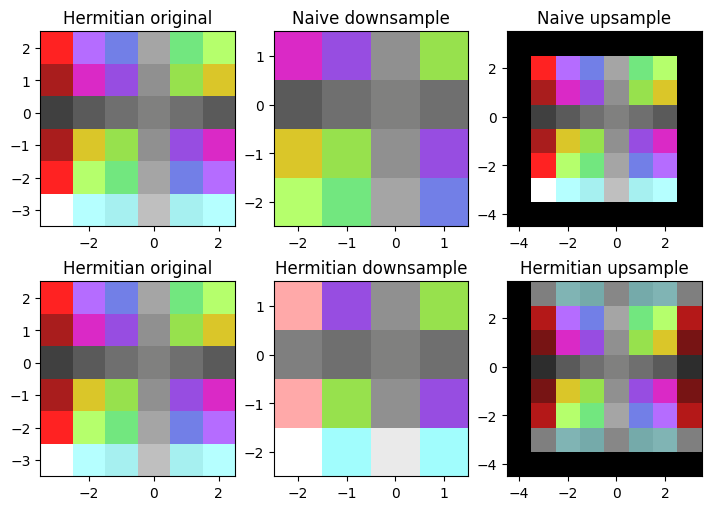

In [11]:
init_shape = 2*(6,)
down_shape = 2*(4,)
up_shape = 2*(8,)

# init_shape = 2*(20,)
# down_shape = 2*(18,)
# up_shape = 2*(22,)

# color_space = 'RGB'
color_space = 'HLS'
fftshift = True
# fftshift = False

phth, _, fourier = make_hermitian_torus(0.5, n_phi=init_shape[0]+1, n_theta=init_shape[1]+1, color_space=color_space)
fourier = fourier[:-1,:-1]

# fourier_down = jnp.moveaxis(fourier, -1, 0)
# fourier_up = jnp.moveaxis(fourier, -1, 0)
# fourier_down = vmap(partial(chreshape, shape=down_shape, rfft=False))(fourier_down)
# fourier_up = vmap(partial(chreshape, shape=up_shape, rfft=False))(fourier_up)
# fourier_down = jnp.clip(jnp.moveaxis(fourier_down, 0, -1), 0, 1)
# fourier_up = jnp.clip(jnp.moveaxis(fourier_up, 0, -1), 0, 1)

fourier_down = vmap(partial(chreshape, shape=down_shape, rfft=False))(fourier.T).T
fourier_up = vmap(partial(chreshape, shape=up_shape, rfft=False))(fourier.T).T
fourier_down = jnp.clip(fourier_down, 0, 1)
fourier_up = jnp.clip(fourier_up, 0, 1)
_fourier_down = vmap(partial(_chreshape, shape=down_shape, rfft=False))(fourier.T).T
_fourier_up = vmap(partial(_chreshape, shape=up_shape, rfft=False))(fourier.T).T

def plot_colormesh(mesh, fftshift=True):
    xm, ym, *_ = mesh.shape
    if fftshift:
        xs = np.fft.fftshift(np.fft.fftfreq(xm) * xm)
        ys = np.fft.fftshift(np.fft.fftfreq(ym) * ym)
        mesh = np.fft.fftshift(mesh, axes=(0,1))
    else:
        # xb, yb = box_size
        # xs, ys = np.linspace(0, xb, xm, endpoint=False), np.linspace(0, yb, ym, endpoint=False)
        xs, ys = np.arange(0, xm), np.arange(0, ym)

    xx, yy = np.meshgrid(xs, ys, indexing='ij')
    plt.pcolormesh(xx, yy, mesh)


plt.figure(figsize=(7,5), layout="constrained")
plt.subplot(231)
plot_colormesh(fourier, fftshift=fftshift)
plt.title("Hermitian original"), plt.gca().set_aspect('equal')
plt.subplot(232)
plot_colormesh(_fourier_down, fftshift=fftshift)
plt.title("Naive downsample"), plt.gca().set_aspect('equal')
plt.subplot(233)
plot_colormesh(_fourier_up, fftshift=fftshift)
plt.title("Naive upsample"), plt.gca().set_aspect('equal')

plt.subplot(234)
plot_colormesh(fourier, fftshift=fftshift)
plt.title("Hermitian original"), plt.gca().set_aspect('equal')
plt.subplot(235)
plot_colormesh(fourier_down, fftshift=fftshift)
plt.title("Hermitian downsample"), plt.gca().set_aspect('equal')
plt.subplot(236)
plot_colormesh(fourier_up, fftshift=fftshift)
plt.title("Hermitian upsample"), plt.gca().set_aspect('equal');

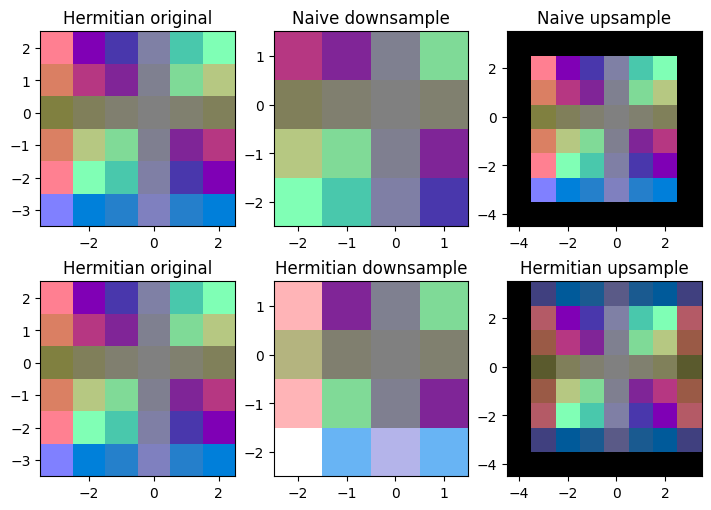

In [5]:
init_shape = 2*(6,)
down_shape = 2*(4,)
up_shape = 2*(8,)

# init_shape = 2*(20,)
# down_shape = 2*(18,)
# up_shape = 2*(22,)

color_space = 'RGB'
# color_space = 'HLS'
fftshift = True
# fftshift = False

phth, _, fourier = make_hermitian_torus(0.5, n_phi=init_shape[0]+1, n_theta=init_shape[1]+1, color_space=color_space)
fourier = fourier[:-1,:-1]

# fourier_down = jnp.moveaxis(fourier, -1, 0)
# fourier_up = jnp.moveaxis(fourier, -1, 0)
# fourier_down = vmap(partial(chreshape, shape=down_shape, rfft=False))(fourier_down)
# fourier_up = vmap(partial(chreshape, shape=up_shape, rfft=False))(fourier_up)
# fourier_down = jnp.clip(jnp.moveaxis(fourier_down, 0, -1), 0, 1)
# fourier_up = jnp.clip(jnp.moveaxis(fourier_up, 0, -1), 0, 1)

fourier_down = vmap(partial(chreshape, shape=down_shape, rfft=False))(fourier.T).T
fourier_up = vmap(partial(chreshape, shape=up_shape, rfft=False))(fourier.T).T
fourier_down = jnp.clip(fourier_down, 0, 1)
fourier_up = jnp.clip(fourier_up, 0, 1)
_fourier_down = vmap(partial(_chreshape, shape=down_shape, rfft=False))(fourier.T).T
_fourier_up = vmap(partial(_chreshape, shape=up_shape, rfft=False))(fourier.T).T

def plot_colormesh(mesh, fftshift=True):
    xm, ym, *_ = mesh.shape
    if fftshift:
        xs = np.fft.fftshift(np.fft.fftfreq(xm) * xm)
        ys = np.fft.fftshift(np.fft.fftfreq(ym) * ym)
        mesh = np.fft.fftshift(mesh, axes=(0,1))
    else:
        # xb, yb = box_size
        # xs, ys = np.linspace(0, xb, xm, endpoint=False), np.linspace(0, yb, ym, endpoint=False)
        xs, ys = np.arange(0, xm), np.arange(0, ym)

    xx, yy = np.meshgrid(xs, ys, indexing='ij')
    plt.pcolormesh(xx, yy, mesh)


plt.figure(figsize=(7,5), layout="constrained")
plt.subplot(231)
plot_colormesh(fourier, fftshift=fftshift)
plt.title("Hermitian original"), plt.gca().set_aspect('equal')
plt.subplot(232)
plot_colormesh(_fourier_down, fftshift=fftshift)
plt.title("Naive downsample"), plt.gca().set_aspect('equal')
plt.subplot(233)
plot_colormesh(_fourier_up, fftshift=fftshift)
plt.title("Naive upsample"), plt.gca().set_aspect('equal')

plt.subplot(234)
plot_colormesh(fourier, fftshift=fftshift)
plt.title("Hermitian original"), plt.gca().set_aspect('equal')
plt.subplot(235)
plot_colormesh(fourier_down, fftshift=fftshift)
plt.title("Hermitian downsample"), plt.gca().set_aspect('equal')
plt.subplot(236)
plot_colormesh(fourier_up, fftshift=fftshift)
plt.title("Hermitian upsample"), plt.gca().set_aspect('equal');

## 3D rfft

shape: (10000, 6, 6, 4)
n_unique comp:  (144,)
n_unique real:  (128,)
n_unique imag:  (120,)
n_unique total:  248 vs. 216 +1 because of zero


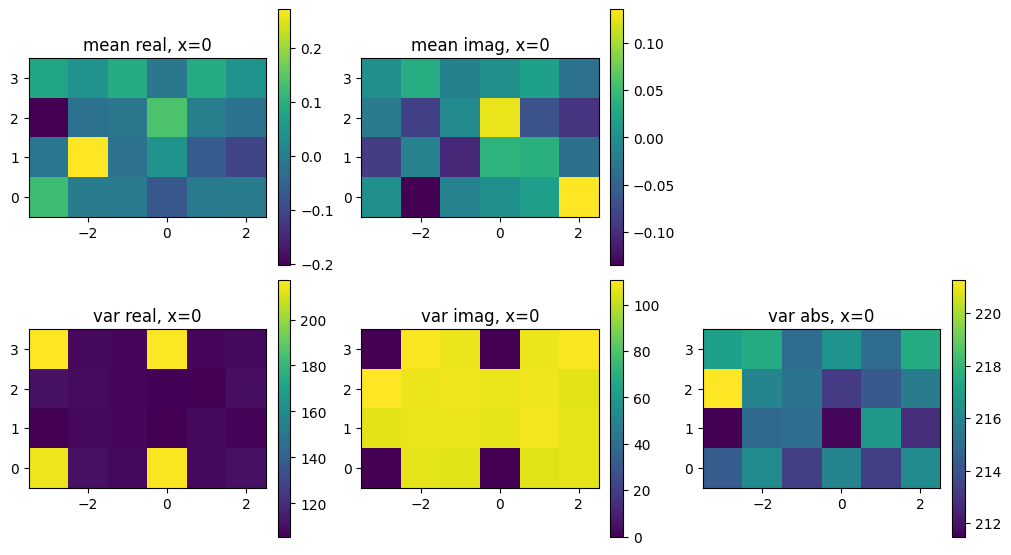

In [6]:
from numpy.testing import assert_allclose
def ch2rshape(shape):
    return (*shape[:-1], 2*(shape[-1]-1))

def r2chshape(shape):
    return (*shape[:-1], shape[-1]//2+1)

def plot_fourier(fourier, ids=0, axis=0):
    n_rep, *shape = fourier.shape
    rshape = ch2rshape(shape)
    xs = np.fft.fftshift(np.fft.fftfreq(rshape[0])*rshape[0])
    ys = np.fft.fftshift(np.fft.fftfreq(rshape[1])*rshape[1])
    zs = np.fft.rfftfreq(rshape[2])*rshape[2]
    xyzs = [xs, ys, zs]

    axids = [0,1,2]
    axids.remove(axids[axis])
    xlab, ylab = np.array(["x", "y", "z"])[axids]
    zlab = np.array(["x", "y", "z"])[axis]
    xs, ys = (xyzs[i] for i in axids)
    xx, yy = np.meshgrid(xs, ys, indexing='ij')

    for i in range(2):
        fourier = np.fft.fftshift(fourier, axes=i+1)
    sliced = np.take(np.array(fourier), ids, axis%3+1)

    plt.figure(figsize=(10,8), layout="constrained")
    plt.subplot(331)
    plt.pcolormesh(xx, yy, sliced.real.mean(0))
    plt.colorbar(), plt.gca().set_aspect(1)
    plt.title(f"mean real, {zlab}={ids}"), 
    # plt.xlabel(xlab), plt.ylabel(ylab)
    plt.subplot(332)
    plt.pcolormesh(xx, yy, sliced.imag.mean(0))
    plt.colorbar(), plt.gca().set_aspect(1)
    plt.title(f"mean imag, {zlab}={ids}"), 
    # plt.xlabel(xlab), plt.ylabel(ylab)

    print("shape:",fourier.shape)
    print("n_unique comp: ", jnp.unique(fourier[0]).shape)
    print("n_unique real: ", jnp.unique(fourier.real[0]).shape)
    print("n_unique imag: ", jnp.unique(jnp.abs(fourier.imag)[0]).shape)
    print("n_unique total: ", jnp.unique(fourier.real[0]).shape[0] + jnp.unique(jnp.abs(fourier.imag)[0]).shape[0], 
          "vs.", shape[0]*shape[1]*(2*(shape[2]-1)), "+1 because of zero")

    var_rea, var_ima, var_abs = (sliced.real**2).mean(0), (sliced.imag**2).mean(0), (jnp.abs(sliced)**2).mean(0)
    plt.subplot(334)
    plt.pcolormesh(xx, yy, var_rea)
    plt.colorbar(), plt.gca().set_aspect(1)
    plt.title(f"var real, {zlab}={ids}"), 
    # plt.xlabel(xlab), plt.ylabel(ylab)
    plt.subplot(335)
    plt.pcolormesh(xx, yy, var_ima)
    plt.colorbar(), plt.gca().set_aspect(1)
    plt.title(f"var imag, {zlab}={ids}"), 
    # plt.xlabel(xlab), plt.ylabel(ylab)
    plt.subplot(336)
    plt.pcolormesh(xx, yy, var_abs)
    plt.colorbar(), plt.gca().set_aspect(1)
    plt.title(f"var abs, {zlab}={ids}"), 
    # plt.xlabel(xlab), plt.ylabel(ylab)
    # j_toplot = 3
    # cov_abs = jnp.cov(jnp.abs(fourier)[:,j_toplot,:,0].T, jnp.abs(fourier)[:,:,j_toplot,0].T)
    # cov_real = jnp.cov(fourier.real[:,j_toplot,:,0].T, fourier.real[:,:,j_toplot,0].T)
    # cov_imag = jnp.cov(fourier.imag[:,j_toplot,:,0].T, fourier.imag[:,:,j_toplot,0].T)

    # fourier = fourier.reshape(n_rep, -1)
    # cov_real = jnp.cov(fourier.real.T, fourier.real.T)
    # cov_imag = jnp.cov(fourier.imag.T, fourier.imag.T)
    # cov_abs = jnp.cov(jnp.abs(fourier).T, jnp.abs(fourier).T)
    # plt.subplot(337)
    # plt.imshow(cov_real)
    # plt.colorbar(), plt.title("cov real"), plt.gca().set_aspect(1)
    # plt.subplot(338)
    # plt.imshow(cov_imag)
    # plt.colorbar(), plt.title("cov imag"), plt.gca().set_aspect(1)
    # plt.subplot(339)
    # plt.imshow(cov_abs)
    # plt.colorbar(), plt.title("cov abs"), plt.gca().set_aspect(1)
    # return cov_abs, cov_real, cov_imag


shape = jnp.array(3*[6])
# shape = jnp.array(3*[8])
# n_rep = int(1e5)
n_rep = int(1e4)
# spatial /= size.prod()**.5
norm = "backward"
# norm = "ortho"
# norm = "forward"
spatial = jr.normal(jr.key(42), (n_rep,*shape))
fourier = vmap(partial(jnp.fft.rfftn, norm=norm))(spatial)

ids = 0
axis = 0
covs_rfftn = plot_fourier(fourier, ids=ids, axis=axis)

In [ ]:
from montecosmo.utils import ch2rshape

def _chreshape2(mesh, shape):
    """
    Naively reshape a complex Hermitian tensor.
    /!\ Does not preserve Hermitian symmetry nor power.
    """
    ids_shape = tuple(np.minimum(mesh.shape, shape))
    scale = np.divide(ch2rshape(shape), ch2rshape(mesh.shape)).prod()

    dtype = 'int16' # int16 -> +/- 32_767, trkl
    ids = tuple(np.roll(np.arange(-(s//2), (s+1)//2, dtype=dtype), -(s//2)) for s in ids_shape[:-1])
    ids += (np.arange(ids_shape[-1], dtype=dtype),)
    
    if ids_shape == shape: # downsample all axis
        out = mesh[np.ix_(*ids)]
    elif ids_shape == mesh.shape: # oversample all axis
        out = jnp.zeros(shape, dtype=complex)
        out = out.at[np.ix_(*ids)].set(mesh)
    else: # down or oversample
        out = jnp.zeros(shape, dtype=complex)
        ids = np.ix_(*ids)
        out = out.at[ids].set(mesh[ids])
    return out * scale
    

def _chreshape(mesh, shape):
    """
    Naively reshape a complex Hermitian tensor.
    /!\ Does not preserve Hermitian symmetry nor power.
    """
    scale = np.divide(ch2rshape(shape), ch2rshape(mesh.shape)).prod()

    # Center wavevectors in mesh to truncate or pad
    for ax, s in enumerate(mesh.shape[:-1]):
        mesh = jnp.roll(mesh, s//2, ax)
    
    slices = ()
    for ax, (ms, s) in enumerate(zip(mesh.shape, shape)):
        trunc = max(ms - s, 0)
        if ax < len(shape) - 1:
            trunc //= 2
            slices += (slice(trunc, None if trunc==0 else -trunc),)
        else:
            slices += (slice(0, None if trunc==0 else -trunc),)
    mesh = mesh[slices]

    pad_width = ()
    for ax, (ms, s) in enumerate(zip(mesh.shape, shape)):
        pad = max(s - ms, 0)
        if ax < len(shape) - 1:
            pad //= 2
            pad_width += ((pad, pad),)
        else:
            pad_width += ((0, pad),)
    mesh = jnp.pad(mesh, pad_width=pad_width)

    # Decenter wavevectors in mesh after truncate or pad
    for ax, s in enumerate(mesh.shape[:-1]):
        mesh = jnp.roll(mesh, -s//2, ax)
    return mesh * scale


def hermitian_symmetric(arr):
    """
    Return the Hermitian symmetric of a tensor (of any dimension and shape).
    A tensor has Hermitian symmetry if it is equal to its Hermitian symmetric.
    """
    dim = len(arr.shape)
    ids = dim * (slice(None, None, -1),)
    arr = arr[ids].conj()
    for ax in range(dim):
        arr = jnp.roll(arr, shift=1, axis=ax)
    return arr


def chreshape(mesh, shape):
    """
    Reshape a complex Hermitian tensor,
    with truncating or padding that preserve the Hermitian symmetry and power.
    """
    mesh = jnp.asarray(mesh)
    # NOTE: reverse axes order to start with last axis, 
    # for the Hermitian symmetric of its only Nyquist hyperplane needs to be constructed first.
    for ax, (ms, s) in reversed(list(enumerate(zip(mesh.shape, shape)))): 
        if s < ms: # truncate axis
            if ax < len(shape) - 1:
                # Aggregate the 2 Nyquist hyperplanes
                neg_ids = (slice(None),) * ax + (-s//2,)
                pos_ids = (slice(None),) * ax + (s//2,)
                mesh = mesh.at[neg_ids].set((mesh[pos_ids] + mesh[neg_ids]) / 2**.5)
            else:
                # Aggregate the Nyquist hyperplane with its constructed Hermitian symmetric
                pos_ids = (slice(None),) * ax + (s - 1,)
                nyq_plane = mesh[pos_ids]
                nyq_plane_sym = hermitian_symmetric(nyq_plane)
                mesh = mesh.at[pos_ids].set((nyq_plane + nyq_plane_sym) / 2**.5)

    out = _chreshape(mesh, shape)

    for ax, (ms, s) in enumerate(zip(mesh.shape, shape)):
        if s > ms: # pad axis
            if ax < len(shape) - 1:
                # Reweight and duplicate the Nyquist hyperplane
                neg_ids = (slice(None),) * ax + (-ms//2,)
                pos_ids = (slice(None),) * ax + (ms//2,)
                out = out.at[neg_ids].divide(2**.5)
                out = out.at[pos_ids].set(out[neg_ids])
            else:
                # Reweight the Nyquist hyperplane
                pos_ids = (slice(None),) * ax + (ms - 1,)
                out = out.at[pos_ids].divide(2**.5)

    return out


shape: (10000, 8, 8, 5)
n_unique comp:  (145,)
n_unique real:  (129,)
n_unique imag:  (119,)
n_unique total:  248 vs. 512 +1 because of zero
shape: (10000, 8, 8, 5)
n_unique comp:  (145,)
n_unique real:  (129,)
n_unique imag:  (120,)
n_unique total:  249 vs. 512 +1 because of zero


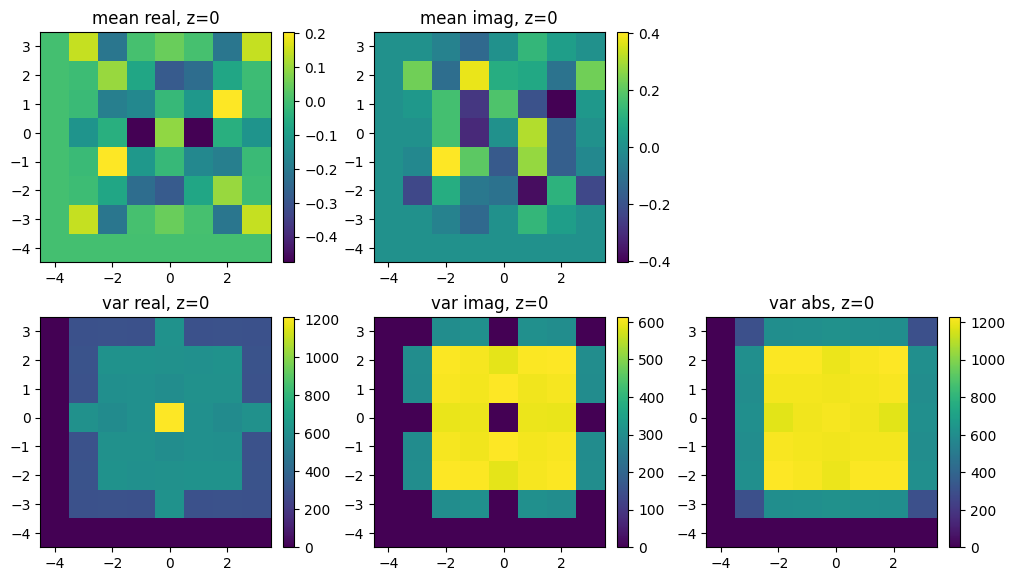

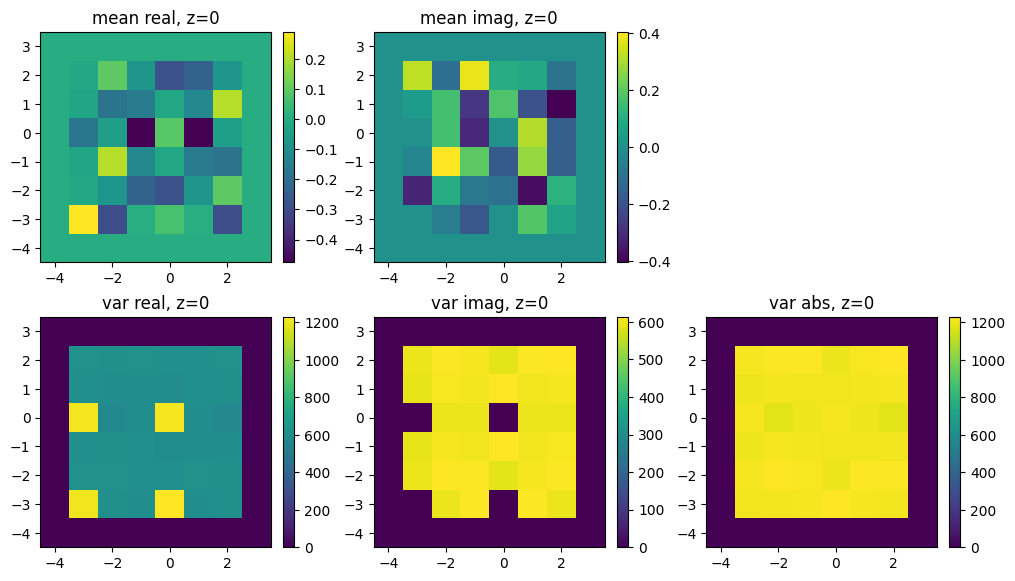

In [10]:
ids = 0
axis = -1
fourier2 = vmap(partial(chreshape, shape=r2chshape([8,8,8])))(fourier)
# fourier2 = vmap(partial(chreshape, shape=r2chshape([6,8,8])))(fourier)
# fourier2 = vmap(partial(chreshape, shape=r2chshape([8,6,6])))(fourier)
# fourier2 = vmap(partial(chreshape, shape=r2chshape([8,8,6])))(fourier)
# fourier2 = vmap(partial(chreshape, shape=r2chshape([6,6,8])))(fourier)
# fourier2 = vmap(partial(chreshape, shape=r2chshape([6,6,6])))(fourier)
covs2 = plot_fourier(fourier2, ids=ids, axis=axis)

fourier12 = vmap(partial(_chreshape, shape=fourier2.shape[1:]))(fourier)
covs2 = plot_fourier(fourier12, ids=ids, axis=axis)
# assert_allclose(fourier2, fourier12)

## When padding, power should be conserved

In [12]:
scale = np.divide(ch2rshape(fourier2.shape),ch2rshape(fourier.shape)).prod()
# (jnp.abs(fourier)**2).mean(), (jnp.abs(fourier2)**2).mean(), (jnp.abs(fourier12)**2).mean()
# (jnp.abs(fourier)**2).sum(), (jnp.abs(fourier2)**2).sum(), (jnp.abs(fourier12)**2).sum()

(jnp.abs(vmap(jnp.fft.irfftn)(fourier))**2).mean(), (jnp.abs(vmap(jnp.fft.irfftn)(fourier2))**2).mean(), (jnp.abs(vmap(jnp.fft.irfftn)(fourier12))**2).mean()
# (jnp.abs(vmap(jnp.fft.irfftn)(fourier))**2).sum()/scale**.5, (jnp.abs(vmap(jnp.fft.irfftn)(fourier2))**2).sum(), (jnp.abs(vmap(jnp.fft.irfftn)(fourier12))**2).sum()

(Array(0.99871416, dtype=float64),
 Array(0.99871416, dtype=float64),
 Array(1.13997446, dtype=float64))

## Output should have Hermitian symmetry

In [17]:
from montecosmo.utils import cgh2rg, cgh2rg2, rg2cgh, rg2cgh2, r2chshape, ch2rshape
from montecosmo.utils import chreshape, _chreshape
from montecosmo.bricks import lin_power_mesh, Planck18
from montecosmo.plot import plot_mesh, plot_pow, plot_bivar
from numpy.testing import assert_allclose

a = 1.
cosmo = Planck18()
box_size = np.array(3*(640,))
norm = "backward"
# norm = "ortho"
# norm = "forward"

# init_shape = 3*(8,)
init_shape = 3*(6,)
# final_shape = (8,8,6,)
# final_shape = (6,6,8,)
final_shape = 3*(8,)
# final_shape = 3*(6,)

init_mesh = jnp.fft.rfftn(jr.normal(jr.key(33), init_shape), norm=norm)
# init_mesh *= lin_power_mesh(cosmo, init_shape, box_size, a)**.5

mesh = chreshape(init_mesh, r2chshape(final_shape))
# mesh = _chreshape(init_mesh, r2chshape(final_shape))
init_mesh2 = rg2cgh(cgh2rg(init_mesh, norm=norm), norm=norm)
mesh2 = rg2cgh(cgh2rg(mesh, norm=norm), norm=norm)

init_mesh.shape, mesh.shape, init_mesh.dtype, mesh.dtype

((6, 6, 4), (8, 8, 5), dtype('complex128'), dtype('complex128'))

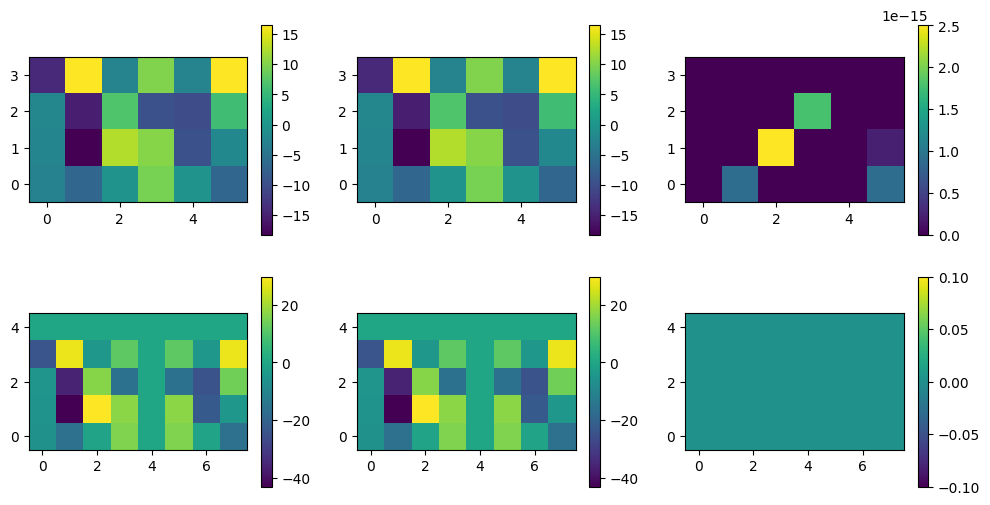

In [18]:
axis = 0
ids = np.array([0])
# ids = 1.

plt.figure(figsize=(12,6))
plt.subplot(231)
plot_mesh(init_mesh.real, axis=axis, ids=ids)
plt.colorbar()
plt.subplot(232)
plot_mesh(init_mesh2.real, axis=axis, ids=ids)
plt.colorbar()
plt.subplot(233)
plot_mesh(jnp.abs(init_mesh2 - init_mesh), axis=axis, ids=ids)
plt.colorbar()

plt.subplot(234)
plot_mesh(mesh.real, axis=axis, ids=ids)
plt.colorbar()
plt.subplot(235)
plot_mesh(mesh2.real, axis=axis, ids=ids)
plt.colorbar()
plt.subplot(236)
plot_mesh(jnp.abs(mesh2 - mesh), axis=axis, ids=ids)
plt.colorbar()
assert_allclose(init_mesh, init_mesh2, rtol=1e-5, atol=1e-5)
assert_allclose(mesh, mesh2, rtol=1e-5, atol=1e-5)

## Output should be invariant under the number of composed reshapings

In [19]:
from montecosmo.utils import rg2cgh, cgh2rg2, rg2cgh, rg2cgh2, r2chshape, ch2rshape
from montecosmo.bricks import lin_power_mesh, Planck18
from montecosmo.plot import plot_mesh, plot_pow, plot_bivar
from numpy.testing import assert_allclose

a = 1.
cosmo = Planck18()
box_size = np.array(3*(640,))
norm = "backward"
# norm = "ortho"
# norm = "forward"

# init_shape = 3*(10,)
# temp_shape = 3*(8,)
# final_shape = 3*(6,)

init_shape = 3*(6,)
temp_shape = 3*(8,)
final_shape = 3*(10,)

init_mesh = jnp.fft.rfftn(jr.normal(jr.key(33), init_shape), norm=norm)
init_mesh *= lin_power_mesh(cosmo, init_shape, box_size, a)**.5

direct_mesh = chreshape(init_mesh, r2chshape(final_shape))
mesh = chreshape(chreshape(init_mesh, r2chshape(temp_shape)), r2chshape(final_shape))

direct_mesh.shape, mesh.shape, direct_mesh.dtype, mesh.dtype

((10, 10, 6), (10, 10, 6), dtype('complex128'), dtype('complex128'))

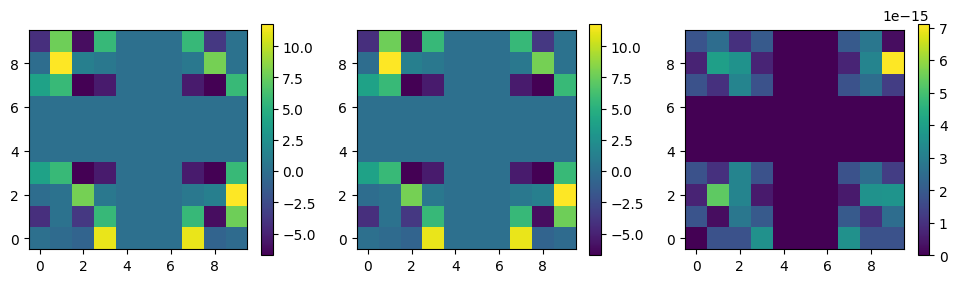

In [20]:
axis = 2
ids = np.array([0])
# ids = 1.

plt.figure(figsize=(12,3))
plt.subplot(131)
plot_mesh(direct_mesh.real, axis=axis, ids=ids)
plt.colorbar()
plt.subplot(132)
plot_mesh(mesh.real, axis=axis, ids=ids)
plt.colorbar()
plt.subplot(133)
plot_mesh(jnp.abs(direct_mesh - mesh), axis=axis, ids=ids)
plt.colorbar()
assert_allclose(direct_mesh, mesh, rtol=1e-5, atol=1e-5)

# Gaussian Linear Model Posterior

In [70]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.mcbench import Chains
config = {
          'mesh_shape':3 * (128,),
          'box_size':3 * (640.,),
          'a_lpt':0.1,
          'a_obs':0.1,
          'lpt_order':1,
          'precond':0,
          'obs':'mesh'
          }
model = FieldLevelModel(**default_config | config)

truth = {'Omega_m': 0.31, 
        'sigma8': 0.81, 
        'b1': 1., 
        'b2':0., 
        'bs2':0., 
        'bn2': 0.}

truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
model.obs_meshk = truth['obs']-1
init_params_ = jit(vmap(partial(model.init_model, base=True)))(jr.split(jr.key(43), 100))

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

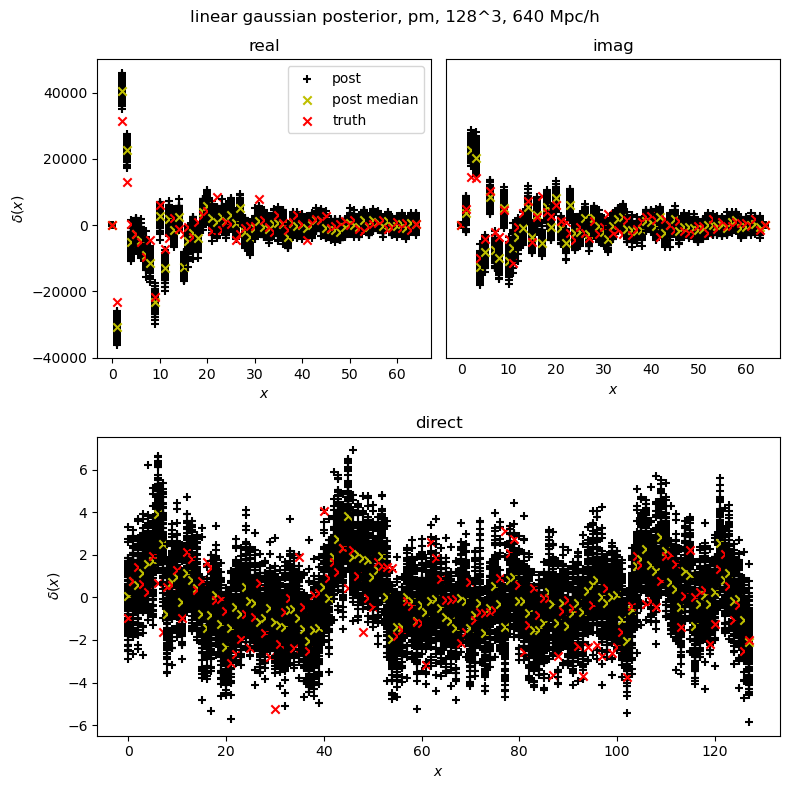

In [60]:
meshes = []
meshes_true = []
i_s = 0
i_st = 0
meshes.append(init_params_['init_mesh'][:,i_s,i_s,i_st:].real)
meshes_true.append(truth['init_mesh'][i_s,i_s,i_st:].real)
meshes.append(init_params_['init_mesh'][:,i_s,i_s,i_st:].imag)
meshes_true.append(truth['init_mesh'][i_s,i_s,i_st:].imag)
meshes.append(vmap(jnp.fft.irfftn)(init_params_['init_mesh'])[:,i_s,i_s,i_st:])
meshes_true.append(jnp.fft.irfftn(truth['init_mesh'])[i_s,i_s,i_st:])

plt.figure(figsize=(8,8))
labels = ['real', 'imag', 'direct']
for i_plt, (mesh, mesh_true) in enumerate(zip(meshes, meshes_true)):
    if i_plt == 0:
        plt.subplot(2,2,i_plt+1)
    elif i_plt == 1:
        plt.subplot(2,2,i_plt+1, sharey=plt.gca())
        plt.gca().tick_params(labelleft=False, length=0)
    elif i_plt == 2:
        plt.subplot(2,1,2)

    for i in range(mesh_true.shape[0]):
        plt.scatter(100*(i,), mesh[:,i], c='k', marker='+', label='post')
        plt.scatter(i, jnp.median(mesh[:,i]), c='y', marker='x', label='post median')
        plt.scatter(i, mesh_true[i], c='r', marker='x', label='truth')
        plt.legend() if i == 0 and i_plt == 0 else None
        plt.xlabel('$x$'), plt.ylabel('$\\delta(x)$') if i_plt==0 or i_plt==2 else None
        plt.title(labels[i_plt])
plt.suptitle('linear gaussian posterior, pm, 128^3, 640 Mpc/h')
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), "init_mesh_pm.svg")

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

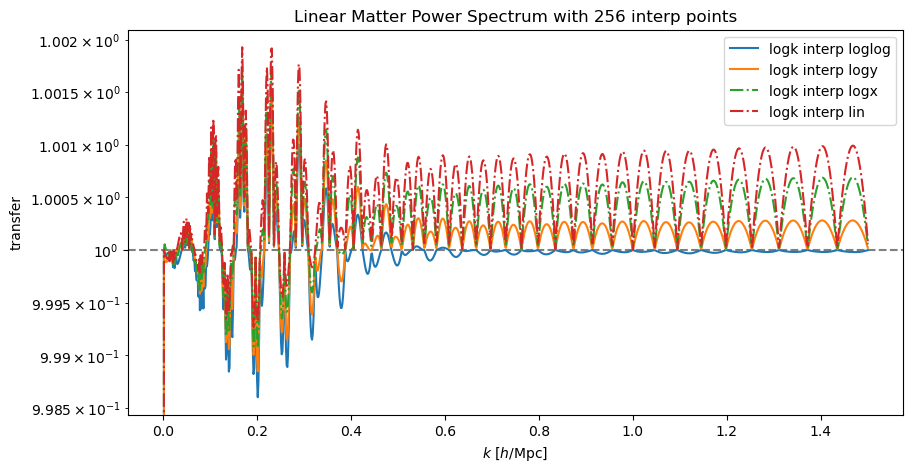

In [6]:
import jax_cosmo as jc
from montecosmo.bricks import Planck18
from montecosmo.plot import plot_pk, plot_trans

def lin_power_interp(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmo, k, a=a)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape(-1), k, pk).reshape(x.shape)
     # equivalent to jnp.interp(..., left="extrapolate", right="extrapolate")
    return pk_fn

def lin_power_interp2(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.linspace(0, 10, n_interp)
    logpk = jnp.log(jc.power.linear_matter_power(cosmo, k, a=a))
    pk_fn = lambda x: jnp.exp(jnp.interp(jnp.log(x.reshape(-1)), jnp.log(k), logpk, left=-jnp.inf, right=-jnp.inf)).reshape(x.shape)
    return pk_fn

def lin_power_interp3(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.linspace(0, 10, n_interp)
    logpk = jnp.log(jc.power.linear_matter_power(cosmo, k, a=a))
    pk_fn = lambda x: jnp.exp(jnp.interp(x.reshape(-1), k, logpk, left=-jnp.inf, right=-jnp.inf)).reshape(x.shape)
    return pk_fn

def lin_power_interp4(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.logspace(-4, 1, n_interp)
    logpk = jnp.log(jc.power.linear_matter_power(cosmo, k, a=a))
    pk_fn = lambda x: jnp.exp(jnp.interp(jnp.log(x.reshape(-1)), jnp.log(k), logpk, left=-jnp.inf, right=-jnp.inf)).reshape(x.shape)
    return pk_fn

def lin_power_interp5(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.logspace(-4, 1, n_interp)
    logpk = jnp.log(jc.power.linear_matter_power(cosmo, k, a=a))
    pk_fn = lambda x: jnp.exp(jnp.interp(x.reshape(-1), k, logpk, left=-jnp.inf, right=-jnp.inf)).reshape(x.shape)
    return pk_fn

def lin_power_interp6(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.linspace(0, 10, n_interp)
    pk = jc.power.linear_matter_power(cosmo, k, a=a)
    pk_fn = lambda x: jnp.interp(jnp.log(x.reshape(-1)), jnp.log(k), pk, left=0., right=0.).reshape(x.shape)
    return pk_fn

def lin_power_interp7(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.linspace(0, 10, n_interp)
    pk = jc.power.linear_matter_power(cosmo, k, a=a)
    pk_fn = lambda x: jnp.interp(x.reshape(-1), k, pk, left=0., right=0.).reshape(x.shape)
    return pk_fn

def lin_power_interp8(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmo, k, a=a)
    pk_fn = lambda x: jnp.interp(jnp.log(x.reshape(-1)), jnp.log(k), pk, left=0., right=0.).reshape(x.shape)
    return pk_fn

def lin_power_interp9(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmo, k, a=a)
    pk_fn = lambda x: jnp.interp(x.reshape(-1), k, pk, left=0., right=0.).reshape(x.shape)
    return pk_fn

n_interp = 256
k_values = jnp.logspace(-4.5, 1, 100)
k_values = jnp.linspace(0, 1.5, 1000)
cosmo = Planck18()
pk_fn0 = lambda k: jc.power.linear_matter_power(cosmo, k)
pk_fn1 = lin_power_interp(cosmo, n_interp=n_interp)
pk_fn2 = lin_power_interp2(cosmo, n_interp=n_interp)
pk_fn3 = lin_power_interp3(cosmo, n_interp=n_interp)
pk_fn4 = lin_power_interp4(cosmo, n_interp=n_interp)
pk_fn5 = lin_power_interp5(cosmo, n_interp=n_interp)
pk_fn6 = lin_power_interp6(cosmo, n_interp=n_interp)
pk_fn7 = lin_power_interp7(cosmo, n_interp=n_interp)
pk_fn8 = lin_power_interp8(cosmo, n_interp=n_interp)
pk_fn9 = lin_power_interp9(cosmo, n_interp=n_interp)

pk_values0 = pk_fn0(k_values)
pk_values1 = pk_fn1(k_values)
pk_values2 = pk_fn2(k_values)
pk_values3 = pk_fn3(k_values)
pk_values4 = pk_fn4(k_values)
pk_values5 = pk_fn5(k_values)
pk_values6 = pk_fn6(k_values)
pk_values7 = pk_fn7(k_values)
pk_values8 = pk_fn8(k_values)
pk_values9 = pk_fn9(k_values)
pk_values0 = jnp.where(pk_values0 == 0., 1., pk_values0)
ks = k_values

plt.figure(figsize=(10, 5))
log = False
# plot_pk(k_values, pk_values0, log=log, label='lin_mat_pow')
# plot_pk(ks, pk_values1, '+:', log=log, label='jc_interp')
# plot_pk(ks, pk_values2, 'x:', log=log, label='k interp loglog')
# plot_pk(ks, pk_values3, '*:', log=log, label='k interp logy')
# plot_pk(ks, pk_values4, 'x', log=log, label='logk interp loglog')
# plot_pk(ks, pk_values5, '*:', log=log, label='logk interp logy')

# plot_trans(ks[1:], ((pk_values1/pk_values0)**.5)[1:], '', log=log, label='jc_interp')
# plot_trans(ks, (pk_values2/pk_values0)**.5, ':', log=log, label='k interp loglog')
# plot_trans(ks, (pk_values3/pk_values0)**.5, ':', log=log, label='k interp logy')
plot_trans(ks, (pk_values4/pk_values0)**.5, '', log=log, label='logk interp loglog')
plot_trans(ks, (pk_values5/pk_values0)**.5, '', log=log, label='logk interp logy')
# plot_trans(ks, (pk_values6/pk_values0)**.5, '--', log=log, label='k interp logx')
# plot_trans(ks, (pk_values7/pk_values0)**.5, '--', log=log, label='k interp lin')
plot_trans(ks, (pk_values8/pk_values0)**.5, '-.', log=log, label='logk interp logx')
plot_trans(ks, (pk_values9/pk_values0)**.5, '-.', log=log, label='logk interp lin')
plt.hlines(1, *plt.xlim(plt.xlim()), color='k', linestyle='--', alpha=.5, zorder=-1)
plt.legend()
plt.title(f'Linear Matter Power Spectrum with {n_interp} interp points')
plt.show()

In [71]:
kpptcs = vmap(lambda x: model.pktranscoh(jnp.fft.irfftn(truth['init_mesh']), jnp.fft.irfftn(x)))(init_params_['init_mesh'])
jnp.shape(jnp.array(kpptcs))

(5, 100, 31)

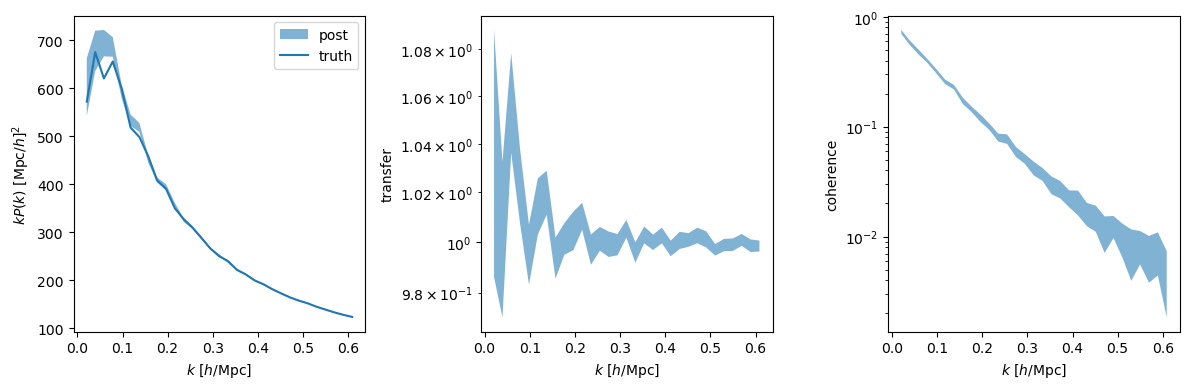

In [74]:
from montecosmo.plot import plot_pktranscoh, plot_pk
log = False
plt.figure(figsize=(12,4))
ks, pk0, pk1, trans, coh = jnp.array(kpptcs)
plot_pktranscoh(ks, pk1, trans, coh, log=log, fill=.68, label='post')
plt.subplot(1,3,1)
plot_pk(ks[0], pk0[0], log=log, label=f"truth")
plt.legend()
plt.tight_layout()

In [14]:
from montecosmo.model import FieldLevelModel, default_config
kpptcss = []
a_obss = [0.1, 0.5, 1.]

for a_obs in a_obss:
    config = {
            'mesh_shape':3 * (128,),
            'box_size':3 * (640.,),
            'a_lpt':0.1,
            'a_obs':a_obs,
            'lpt_order':1,
            'precond':0,
            'obs':'mesh'
            }
    model = FieldLevelModel(**default_config | config)

    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    model.obs_meshk = truth['obs']-1
    init_params_ = jit(vmap(partial(model.init_model, base=True)))(jr.split(jr.key(43), 100))

    kpptcs = vmap(lambda x: model.pktranscoh(jnp.fft.irfftn(truth['init_mesh']), jnp.fft.irfftn(x)))(init_params_['init_mesh'])
    print(jnp.shape(jnp.array(kpptcs)))
    kpptcss.append(kpptcs)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

(5, 100, 31)


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

n_solvsteps: 4


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


(5, 100, 31)


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

n_solvsteps: 5


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


(5, 100, 31)


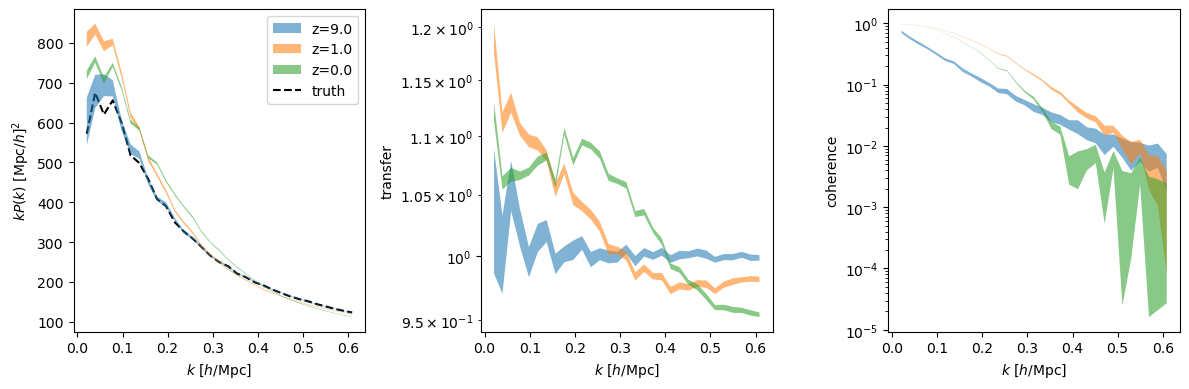

In [15]:
from montecosmo.plot import plot_pktranscoh, plot_pk
log = False
plt.figure(figsize=(12,4))
for i_plt, kpptcs in enumerate(kpptcss):
    ks, pk0, pk1, trans, coh = jnp.array(kpptcs)
    plot_pktranscoh(ks, pk1, trans, coh, log=log, fill=.68, label=f"z={1/a_obss[i_plt]-1:.1f}")
plt.subplot(1,3,1)
plot_pk(ks[0], pk0[0], 'k--', log=log, label=f"truth", zorder=-1)
plt.legend()
plt.tight_layout()

# NUFFT

In [2]:
from jax_finufft import nufft1
from montecosmo.bricks import lin_power_mesh, Planck18, regular_grid
from montecosmo.nbody import lpt, paint, interlace
cosmo = Planck18()
mesh_shape = np.array(3*(64,))
box_size = np.array(3*(2000.,))
pmesh = lin_power_mesh(cosmo, mesh_shape, box_size)
mesh = jr.normal(jr.key(0), mesh_shape)
mesh = jnp.fft.rfftn(mesh)
mesh *= pmesh**.5

pos = regular_grid(mesh_shape)
dpos, vel = lpt(cosmo, mesh, pos, a=1/(1+0.8), lpt_order=2, grad_fd=False, lap_fd=False)
pos += dpos

paint_mesh = interlace(pos, mesh_shape, paint_order=2, interlace_order=2, deconv=True)

ModuleNotFoundError: No module named 'jaxlib.xla_extension'